In [785]:
from __future__ import division
import pickle
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import matplotlib.pyplot as plt
import pyLDAvis.gensim
import gensim.corpora

import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 12, 8 # plotsize

import gensim.models.ldamodel as ldamodel
%matplotlib inline
pyLDAvis.enable_notebook()

In [786]:
d = pickle.load(open('data/comments_data_processed_tech.p','rb'))
comments = d['comments']
sentiments = d['sentiments']
comments_with_sentiments = pd.merge(comments,sentiments,on=['project_id','comment_id'],how='inner')
comments_with_sentiments.head(1)

# load stop words
stop_words_from_web = pickle.load(open('stop_words_from_web.p','rb'))['stop_words']
stop_words_list = [x for x in stop_words_from_web]
[stop_words_list.remove(x) for x in ['0', 'not','after', 'afterwards',  'again', 'later', 'love', 'none', 'unless', 'unlike', 'until', 'only', 'neither', 'against','unlikely','asked','everyone','everything','good'] if x in stop_words_list]
stop_words_list = stop_words_list + ['.','<','>','?','!',',']
stop_words_list = stop_words_list + ['$','(',')',"'","n't","'ll",":","-",";","'d","'ve","'re","...", "''", "``"]

## Remove high idf words

In [787]:
# group all comments by project
comments_processed = comments_with_sentiments.copy(deep=True)
g = comments_processed.groupby('project_id')

df_comments_processed_combined = None
count = 0
for proj_key, df_val in g:
    # concatentate all comments together
    combined_comment = ' '.join(df_val['comment'].values) 
    combined_comment = combined_comment.lower()
    
    # remove punctuation
    
    df0 = pd.DataFrame({'project_id':proj_key, 'all_text':combined_comment}, index=[count])
    count = count + 1
    if df_comments_processed_combined is None:
        df_comments_processed_combined = df0
    else:
        df_comments_processed_combined = pd.concat([df_comments_processed_combined, df0])

In [788]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stopwords.words('english'), analyzer='word');
tfidf.fit(df_comments_processed_combined['all_text'].values);              

In [789]:
df_tfidf = pd.DataFrame(tfidf.vocabulary_.keys(),tfidf.vocabulary_.values())
df_tfidf['idf'] = tfidf.idf_[tfidf.vocabulary_.values()] # ordered by keys in vocabulary dictionary
df_tfidf.sort(columns='idf',ascending=False,inplace=True) # highest idf = lowest doc frequency

idf_cutoff = 7
df_tfidf_non_specific = df_tfidf[df_tfidf['idf'] < idf_cutoff]
stop_words_idf = df_tfidf[df_tfidf['idf'] > idf_cutoff][0].values

stop_words_full = stop_words_list + list(stop_words_idf)

## Separate comments from backers and creators

In [9]:
comments_with_sentiments.head(2)

project_id  comment_id                                            comment  \
0  1842798593           0  What an awesome tool and you are just the pers...   
1  1842798593           1  Awesome to see your past your goal, good luck ...   

        date                       user  sentiment  word_count  
0 2013-11-15  James E. Vivian (deleted)          1          42  
1 2013-11-07                Tony Olsson          1          14

In [790]:
def get_commentor(row):
    if 'Creator' in row['user']:
        return 'creator'
    else:
        return 'backer'
comments_with_sentiments_user = comments_with_sentiments.copy(deep=True)
comments_with_sentiments_user['commentor_type'] = comments_with_sentiments_user.apply(get_commentor,axis=1)

In [791]:
df_creator = comments_with_sentiments_user[comments_with_sentiments_user['commentor_type']=='creator'].copy(deep=True)
df_backer = comments_with_sentiments_user[comments_with_sentiments_user['commentor_type']=='backer'].copy(deep=True)

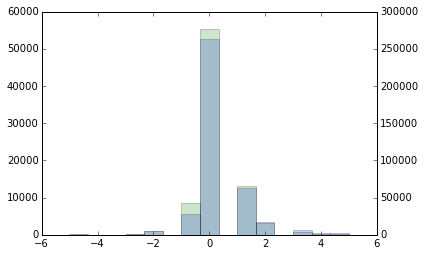

In [56]:
def window(x):
    if x < -5:
        return -5
    if x > 5:
        return 5
    else:
        return x
ax1 = plt.gca()
ax1.hist(map(window, df_creator['sentiment'].values),bins=15,alpha=0.2);
ax2 = ax1.twinx()
ax2.hist(map(window, df_backer['sentiment'].values),bins=15, alpha=0.2, color='g');

## Pool into 3-month intervals

In [792]:
def pool_comments(df0):
    
    df = df0.copy(deep=True)
    grouper = pd.TimeGrouper("1M")
    comments_grouped = None
    grouped_proj = df.groupby('project_id')

    count = 0
    for proj_key, df_val in grouped_proj:
        
#        return df_val
        # for each project, group into time periods and combine comments
     #       df_val.reset_index(inplace=True)
        df_val_grouped = df_val.set_index('date').groupby(grouper) # group into chunks
        
        for key, val in df_val_grouped:
            
            if val.shape[0] == 0:
                # do nothing
                x=3
            else:
                combined_comment = ' '.join(val['comment'].values)
                combined_comment = combined_comment.lower()

                # read into full dataframe
                df0 = pd.DataFrame({'project_id':proj_key, 'date':key, 'comment':combined_comment},index=[count])
                count = count + 1
                if comments_grouped is None:
                    comments_grouped = df0
                else:
                    comments_grouped = pd.concat([comments_grouped, df0])
    return comments_grouped

In [793]:
creator_comments_grouped = pool_comments(df_creator)
backer_comments_grouped = pool_comments(df_backer)

## Tokenize, remove stop words

In [246]:
def process_text(df, stop_words):
    # tokenize text (assumed lower case)
    tokenized = df.copy(deep=True)
    tokenized['tokenized'] = tokenized['comment'].apply(word_tokenize)
    
    # remove stop words
    stop_words_set = set(stop_words)
    stopped = tokenized.copy(deep=True)
    #stopped['stopped'] = stopped['tokenized'].apply(lambda x: list(set(x) - stop_words_set))
    stopped['stopped'] = stopped['tokenized'].apply(lambda X: [x for x in X if x not in stop_words_set])
    return stopped
    
def run_lda(df, num_topics=30): # dataframe with stop words removed
    texts = df['stopped'].values # list of split, lowered, tokenized words with stop words removed, NOT STEMMED
    dictionary = gensim.corpora.Dictionary(texts)

    id2word = {}
    for word in dictionary.token2id:    
        id2word[dictionary.token2id[word]] = word
    
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    lda = ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=10, iterations=200)
    return lda, corpus, dictionary, id2word

In [247]:
creator_processed = process_text(creator_comments_grouped, stop_words_full)
backer_processed = process_text(backer_comments_grouped, stop_words_full)

In [248]:
n_topics = 30
lda_creator, corpus_creator, dictionary_creator, id2word_creator = run_lda(creator_processed,n_topics)
lda_backer, corpus_backer, dictionary_backer, id2word_backer = run_lda(backer_processed, n_topics)

In [256]:
lda_dir = 'lda_grouped_v2/'
lda_backer.save(lda_dir + 'lda_backer')
lda_creator.save(lda_dir + 'lda_creator')

In [472]:
to_save_creator = {'corpus':corpus_creator,'dictionary':dictionary_creator,'id2word':id2word_creator,'n_topics':n_topics,'stop_words':stop_words_full, 'comments':creator_processed}
to_save_backer = {'corpus':corpus_backer,'dictionary':dictionary_backer,'id2word':id2word_backer,'n_topics':n_topics,'stop_words':stop_words_full, 'comments':backer_processed}

pickle.dump(to_save_creator, open(lda_dir + 'data_creator.p', 'wb'))
pickle.dump(to_save_backer, open(lda_dir + 'data_backer.p', 'wb'))

In [249]:
pyLDAvis.gensim.prepare(lda_backer, corpus_backer, dictionary_backer)

/Users/alexmccauley/anaconda/lib/python2.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:107: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00266993409582 and the largest is 0.552177403668.
  RuntimeWarning


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
15     11.430932        1       1 -0.081160  0.122467
23     10.615510        1       2 -0.105083  0.132429
26      7.769357        1       3 -0.110557  0.006408
27      7.120491        1       4 -0.102515  0.127479
10      6.126473        1       5 -0.080184  0.122173
22      6.029028        1       6 -0.100759 -0.060882
25      5.054267        1       7 -0.072747 -0.010511
1       4.879517        1       8 -0.090121  0.004903
0       4.495389        1       9 -0.080281 -0.106196
28      4.476253        1      10 -0.088079 -0.105286
2       4.298606        1      11 -0.099142  0.030746
14      4.014536        1      12 -0.100032 -0.068533
12      3.599166        1      13 -0.104228 -0.035107
21      3.272171        1      14 -0.090855 -0.147417
16      2.785035        1      15 -0.092709 -0.018024
5       2.676085        1      16 -0.071604  0.008001
18      2.614353        1      17 -0.098250 -0.068699
4       2.127691        1      18 -0.079459  0.077160
29      1.197839        1      19 -0.006050  0.090883
13      1.065827        1      20 -0.031159 -0.148081
17      1.037921        1      21  0.130303  0.222546
20      1.015934        1      22 -0.006147  0.106179
3       0.700899        1      23  0.086974 -0.218535
8       0.353476        1      24  0.059914  0.021626
11      0.302113        1      25  0.161943 -0.082489
24      0.270659        1      26  0.205805  0.019772
9       0.227010        1      27  0.234676 -0.033433
7       0.178874        1      28  0.269159 -0.042798
6       0.176831        1      29  0.155795  0.026088
19      0.087756        1      30  0.386553  0.027131, topic_info=      Category           Freq         Term   Total  loglift  logprob
101    Default   27881.000000           --   27881  30.0000  30.0000
91     Default   34264.000000       update   34264  29.0000  29.0000
42     Default  111724.000000            @  111724  28.0000  28.0000
31     Default   39442.000000       thanks   39442  27.0000  27.0000
343    Default   28590.000000     shipping   28590  26.0000  26.0000
270    Default   33019.000000  kickstarter   33019  25.0000  25.0000
403    Default   22932.000000     received   22932  24.0000  24.0000
445    Default   14010.000000      updates   14010  23.0000  23.0000
835    Default   13478.000000      printer   13478  22.0000  22.0000
451    Default   18184.000000          app   18184  21.0000  21.0000
28     Default   41907.000000      project   41907  20.0000  20.0000
339    Default    9726.000000         sent    9726  19.0000  19.0000
425    Default   10120.000000            &   10120  18.0000  18.0000
1094   Default   12372.000000       refund   12372  17.0000  17.0000
632    Default    9594.000000        power    9594  16.0000  16.0000
257    Default   16521.000000           hi   16521  15.0000  15.0000
306    Default   26895.000000       please   26895  14.0000  14.0000
24     Default  121117.000000          not  121117  13.0000  13.0000
469    Default    6562.000000       iphone    6562  12.0000  12.0000
816    Default   21757.000000         guys   21757  11.0000  11.0000
198    Default    9677.000000      comment    9677  10.0000  10.0000
99     Default   94687.000000           's   94687   9.0000   9.0000
410    Default   29764.000000          use   29764   8.0000   8.0000
747    Default   29322.000000      product   29322   7.0000   7.0000
19     Default    8073.000000        light    8073   6.0000   6.0000
47     Default    6691.000000        board    6691   5.0000   5.0000
14573  Default    7063.000000         pono    7063   4.0000   4.0000
307    Default   21799.000000       pledge   21799   3.0000   3.0000
521    Default   13441.000000       device   13441   2.0000   2.0000
381    Default   27551.000000         work   27551   1.0000   1.0000
...        ...            ...          ...     ...      ...      ...
19678  Topic30      1

In [522]:
lda_backer.show_topic(23,10)

[(0.029703293611544744, u'not'),
 (0.02223215169233789, u'project'),
 (0.015882263091839648, u'backers'),
 (0.015752197384213896, u'kickstarter'),
 (0.015027050627448699, u'product'),
 (0.012408357589130661, u'refund'),
 (0.011931668347799611, u"'s"),
 (0.011701282288494782, u'money'),
 (0.0084139429872144636, u'update'),
 (0.0077663708565615967, u'people')]

In [523]:
word_to_index['refund']

1094

In [794]:
from collections import defaultdict

In [423]:
# build word:index dictionary, and topic by word_proportion matrix
topic_list = range(n_topics)
word_to_index = defaultdict(dict)

n_rows = len(dictionary_backer)
n_cols = n_topics
topic_df = pd.DataFrame(data=np.zeros([n_rows, n_cols]),columns=range(n_cols))

for key in dictionary_backer:
    word = dictionary_backer[key]
    word_to_index[word] = key

for col in topic_list:    
    for x in lda_backer.show_topic(col, len(dictionary_backer)):    
        word = x[1]
        row = word_to_index[word]
        val = x[0]
        topic_df.loc[row][col] = val # topic_df contains P(word|topic)

In [459]:
pickle.dump(topic_df, open('lda_grouped_v2/topic_df_backer.p','wb'))

## More text processing, with bigrams

In [795]:
onecorp = backer_comments_grouped['comment'].values

In [796]:
wnl = nltk.stem.WordNetLemmatizer()
import re

def lowertitle(word):
        if word.istitle():
            word = word.lower()
        return word

def doc_lower_title(doc):
    return " ".join([lowertitle(word) for word in doc.split()])

def corpus_lower_title(corpus):
    return [doc_lower_title(doc) for doc in corpus]

def lemmatize_doc(doc):
    return " ".join([wnl.lemmatize(i) for i in nltk.word_tokenize(doc)])

def lemmatize_corpus(prepared_corpus):
    lem_corpus = []
    for doc in prepared_corpus:
        lem_corpus.append(lemmatize_doc(doc))
    return lem_corpus

def alphanum_prep_corpus(corpus, num=True):
    if num:
        regex = re.compile('[^a-zA-Z0-9]')
    else:
        regex = re.compile('[^a-zA-Z]')
    #corpus = [' '.join(j.decode('cp1250').encode('ascii', 'ignore').split()) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.com', '', j) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.net', '', j) for j in corpus]
    corpus = [re.sub(r'https?:\/\/.*\.html', '', j) for j in corpus]
    corpus = [re.sub(r'[\']', '', j) for j in corpus]
    corpus = [re.sub(r'[\"]', ' ', j) for j in corpus]
    corpus = [regex.sub(' ', j) for j in corpus]
    return corpus_lower_title(corpus)

# bigrams/trigrams infered from Naive Bayes analysis of MT comments
good_bigrams = ['cant wait', 'not wait', 'looking forward', 'got mine', 'wait get', 'thank much', 'im glad', 'really excited', 'congrats guys', 'wait see']
bad_bigrams = ['took money', 'still waiting', 'months ago', 'months since', 'hasnt arrived', 'not arrived', 'not received' ]
good_trigrams = ['received mine today']
ngrams = good_bigrams + bad_bigrams + good_trigrams

def process_ngrams(n_gram_list, corpus):
    for ngram in n_gram_list:
        ngram_ = re.sub(' ', '_', ngram)
        corpus = [re.sub(ngram, ngram_, j) for j in corpus]
    return corpus

alphacorp = alphanum_prep_corpus(onecorp, num=False)
alphacorp_ngram = process_ngrams(ngrams, alphacorp)
alphalemmcorp = lemmatize_corpus(alphacorp_ngram)

In [797]:
corp_tokenized = [word_tokenize(j) for j in alphalemmcorp]

In [798]:
stop_words_set = set(stop_words_full)
corp_stopped = [[word for word in comm if (word not in stop_words_set)] for comm in corp_tokenized]

In [799]:
alphadic = gensim.corpora.Dictionary(corp_stopped)
alphacorp = [alphadic.doc2bow(txt) for txt in corp_stopped]
alphalda = gensim.models.LdaModel(alphacorp, num_topics=30, passes=10, id2word=alphadic)

In [800]:
pyLDAvis.gensim.prepare(alphalda, alphacorp, alphadic)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      10.621816        1       1  0.119690 -0.164987
9       9.548741        1       2  0.112057 -0.149032
8       8.254942        1       3  0.117230 -0.032219
13      7.081225        1       4  0.123072 -0.120475
5       5.993697        1       5  0.100288 -0.026838
1       5.886779        1       6  0.103188 -0.046605
28      5.455701        1       7  0.075199 -0.181479
18      4.565652        1       8  0.116350  0.100004
4       4.425115        1       9  0.090946  0.093611
6       4.045671        1      10  0.077368  0.088510
25      3.483688        1      11  0.061430 -0.195296
26      3.323455        1      12  0.049960  0.015221
29      3.307165        1      13  0.086838  0.012130
14      3.063970        1      14  0.076014  0.128874
16      2.991916        1      15  0.085242  0.048735
2       2.863675        1      16  0.106359 -0.050739
21      2.846997        1      17  0.070276  0.136726
0       2.393217        1      18  0.078948  0.080140
22      1.657893        1      19  0.010969  0.157921
15      1.551906        1      20  0.002114  0.007667
23      1.263551        1      21  0.017627  0.069793
10      1.026764        1      22 -0.038369  0.003000
12      0.902335        1      23 -0.078351  0.171454
24      0.711197        1      24 -0.138453 -0.074144
3       0.642242        1      25 -0.106898 -0.046567
27      0.537038        1      26 -0.165295  0.118939
17      0.526918        1      27 -0.225225  0.139342
19      0.478001        1      28 -0.273294 -0.168277
11      0.310307        1      29 -0.303333 -0.109850
20      0.238427        1      30 -0.351948 -0.005558, topic_info=      Category          Freq          Term  Total  loglift  logprob
82     Default  27256.000000        update  27256  30.0000  30.0000
373    Default   9812.000000           app   9812  29.0000  29.0000
1236   Default   6510.000000        refund   6510  28.0000  28.0000
26     Default  24501.000000       project  24501  27.0000  27.0000
325    Default  10981.000000      received  10981  26.0000  26.0000
933    Default   7467.000000         email   7467  25.0000  25.0000
232    Default   9598.000000        pledge   9598  24.0000  24.0000
39     Default   4415.000000         board   4415  23.0000  23.0000
392    Default   4119.000000        iphone   4119  22.0000  22.0000
438    Default   7119.000000       battery   7119  21.0000  21.0000
267    Default  13765.000000      shipping  13765  20.0000  20.0000
1872   Default   6246.000000         phone   6246  19.0000  19.0000
231    Default  13372.000000        please  13372  18.0000  18.0000
24     Default   9889.000000        people   9889  17.0000  17.0000
698    Default   8413.000000        device   8413  16.0000  16.0000
92     Default   6321.000000           add   6321  15.0000  15.0000
672    Default   4309.000000       printer   4309  14.0000  14.0000
1617   Default   5071.000000        survey   5071  13.0000  13.0000
1359   Default   3767.000000         color   3767  12.0000  12.0000
83     Default   5917.000000         video   5917  11.0000  11.0000
22     Default   6211.000000         money   6211  10.0000  10.0000
200    Default  13392.000000   kickstarter  13392   9.0000   9.0000
18     Default   5693.000000         light   5693   8.0000   8.0000
3056   Default   2417.000000        camera   2417   7.0000   7.0000
307    Default  16574.000000          work  16574   6.0000   6.0000
2310   Default   3957.000000       android   3957   5.0000   5.0000
30     Default  20820.000000        thanks  20820   4.0000   4.0000
2698   Default   3042.000000         black   3042   3.0000   3.0000
263    Default   5122.000000          sent   5122   2.0000   2.0000
125    Default   6411.000000          case   6411   1.0000   1.0000
...        ...           ...           ...    ...      ...      ...
14789  Topic30    177.742737    matchstick    179   5

Topics relating to project status:

1: pledging (neutral) [visual 6]

5: pledging (very positive): "cant_wait" [visual 5]

7: delays, shipping [visual 1]

8: projects, backers [visual 3]

9: more on project status, "money", some very negative words [visual 2]

11: legal, related to patent issues? [visual 29] - this is very far from the other topics

13: "received mine today", "got_min" [visual 4]

25: shipping, "not_received", "still_waiting" [visual 11]

28: "refund" [visual 7]

## Inference - train sentiment classifier

In [802]:
results = pd.read_csv('random_comments_mt_tech_results.csv')

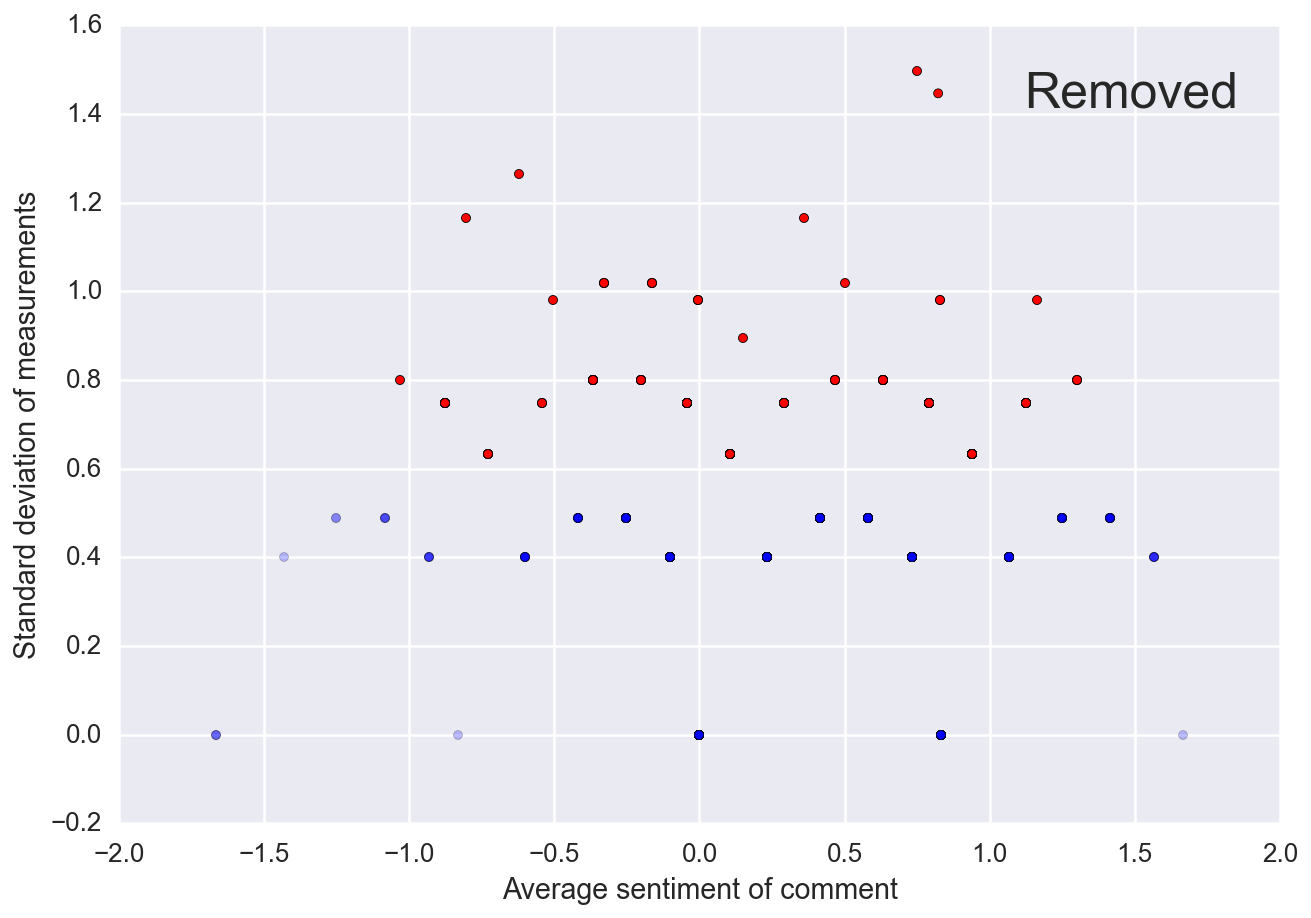

In [613]:
d = results[['Answer1','Answer2','Answer3','Answer4','Answer5']].copy(deep=True)
d['std'] = d.apply(lambda row:np.std(row),axis=1)
d['avg'] = d.apply(lambda row:np.mean(row),axis=1)
plt.scatter(d['avg'],d['std'],alpha=0.25)
plt.xlabel('Average sentiment of comment');
plt.ylabel('Standard deviation of measurements');
d0 = d[d['std']>0.5];
plt.scatter(d0['avg'],d0['std'],c='r',label='Removed')
plt.legend(fontsize=25)

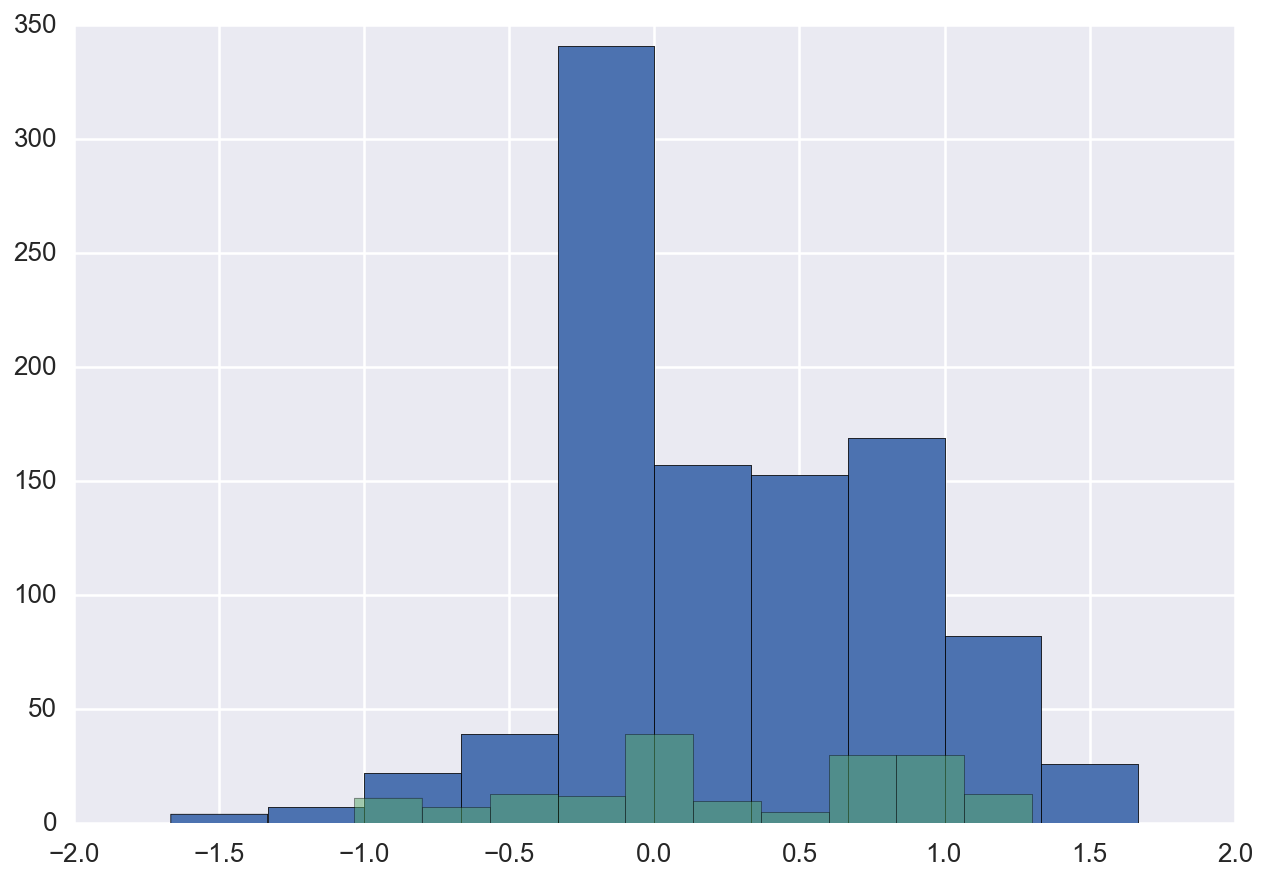

In [610]:
plt.hist(d['avg'])
a = d0['avg'].values
plt.hist(a,alpha=0.5);

In [279]:
len(d[d['std']>0.5]) # SD of uniform distribution is ~1.3

170

In [751]:
# turn comment into corpus format (for inference)
def process_comment_2(comment):
    tok = word_tokenize(comment)
    stop_words_set = set(stop_words_full)
    stop = [word for word in tok if (not word in stop_words_set)]
    corp = [alphadic.doc2bow(stop)]
    return corp

In [741]:
# return infered topic distribution
def inf(comment):
    inf_vec = alphalda.inference(process_comment_2(comment))[0] - 0.0333    
    return inf_vec[0]

In [896]:
# input features are n_samples x n_features - each feature is a topic vector
df_un = None
for ii in range(results.shape[0]):
    comment = results.iloc[ii]['comments']    
    df0 = pd.DataFrame([inf(comment)], index=[ii])
    df0['comment'] = comment
    if df_un is None:
        df_un = df0
    else:
        df_un = pd.concat([df_un, df0])
# normalize rows
#df = df_un / df_un.sum(axis=1)

In [907]:
df_samp = df[[3,4,6,7,26,29]].copy(deep=True)
for ii in range(df_samp.shape[0]):
    row = df_samp.iloc[ii]
    df_samp.iloc[ii] = row / np.sum(row)
df_samp['comment'] = df['comment'].copy(deep=True)

In [909]:
df_samp['Y_meas'] = results['Avg']

In [911]:
df_samp.head(20)

3         4         6         7        26        29  \
0   0.000003  0.000003  0.000003  0.000003  0.999985  0.000003   
1   0.205848  0.000003  0.000003  0.643794  0.150349  0.000003   
2   0.000011  0.000011  0.999944  0.000011  0.000011  0.000011   
3   0.000017  0.000017  0.999917  0.000017  0.000017  0.000017   
4   0.000033  0.000033  0.999833  0.000033  0.000033  0.000033   
5   0.999968  0.000006  0.000006  0.000006  0.000006  0.000006   
6   0.000007  0.000007  0.999967  0.000007  0.000007  0.000007   
7   0.000007  0.000007  0.000007  0.999964  0.000007  0.000007   
8   0.166667  0.166667  0.166667  0.166667  0.166667  0.166667   
9   0.000033  0.000033  0.000033  0.999833  0.000033  0.000033   
10  0.999973  0.000005  0.000005  0.000005  0.000005  0.000005   
11  0.000011  0.000011  0.000011  0.999944  0.000011  0.000011   
12  0.000002  0.000002  0.147047  0.777980  0.074967  0.000002   
13  0.000011  0.000011  0.000011  0.666755  0.333201  0.000011   
14  0.000011  0.000011  0.659547  0.000011  0.340408  0.000011   
15  0.000017  0.000017  0.999917  0.000017  0.000017  0.000017   
16  0.999944  0.000011  0.000011  0.000011  0.000011  0.000011   
17  0.000004  0.000004  0.808862  0.000004  0.191122  0.000004   
18  0.000033  0.000033  0.999833  0.000033  0.000033  0.000033   
19  0.000032  0.999841  0.000032  0.000032  0.000032  0.000032   

                                              comment  Y_meas  
0   This project had been so heartfelt and excitin...     2.0  
1   Im so friggin thrilled I cant stand it! Thomas...     1.8  
2   Congratulations on the funding !!! im super ex...     1.8  
3   You all rock! Every single one of you! Thank you!     1.8  
4             yeaaaaah !!!! Congrat ! you guys rock !     1.8  
5   Got my board today, it is AMAZING! It feels so...     1.8  
6   Congrats on making the goal! Really excited to...     1.8  
7   As a backer of Alans previous book projects, I...     1.6  
8                              Love the mascot Jerry!     1.6  
9           Neil  Were stoked!  The more the merrier!     1.6  
10  Hi Chris, I have received my lilbot and have b...     1.6  
11  Absolutely insane. You people are the best peo...     1.6  
12  Thanks so much guys! Seriously I couldnt have ...     1.6  
13  Cannot wait for this conferenceevent. What a w...     1.6  
14  Its really amazing, hope you bring PocketLab t...     1.6  
15  I hope this gets funded. Looks like great fun ...     1.6  
16           The shipment finally arrived! Awesome!!!     1.6  
17  This is really brilliant. Fair play to everyon...     1.6  
18                           Thank you!!! So awesome!     1.6  
19  I dont know how you do it but I love it, all t...     1.6

### Group sentiments together in chunks then fit model

In [978]:
# Group sentiments by Y_meas and then evaluate topics
n_combine = 10 # combine into groups of this size
df_combined0 = results[['comments', 'Avg']].copy(deep=True).sort('Avg',ascending=True)
df_combined0['idx'] = map(lambda x: int(x//n_combine) , range(df_combined0.shape[0]))
df_combined_comment = df_combined0.groupby('idx').agg(lambda x: ' '.join(x))['comments'].reset_index()
df_combined_avg = df_combined0.groupby('idx').agg(np.mean)['Avg'].reset_index()

df_combined = pd.merge(df_combined_comment, df_combined_avg, on='idx', how='inner')

In [981]:
df_combined.head(10)

idx                                           comments   Avg
0    0  If the exoskeleton is the only thing on backor... -1.66
1    1  No doubt. This is a goner Ian  I have no reaso... -1.22
2    2  Hmm, it only records one half of the conversat... -1.12
3    3  Finally got my solarade last week after months... -0.88
4    4  It has been well over a month since production... -0.78
5    5  Oh Mark Hobbs, with their track record, gettin... -0.60
6    6  How about a Shipping Update since its now JUNE... -0.60
7    7  Used a few times  now no longer charges anythi... -0.50
8    8  Still waiting for tracking ! Hi there, ill kno... -0.40
9    9  Hello, Could you please provide an update when... -0.40

In [1015]:
# input features are n_
# samples x n_features - each feature is a topic vector
df_g_un = None
for ii in range(df_combined.shape[0]):
    comment = df_combined.iloc[ii]['comments']    
    df0 = pd.DataFrame([inf(comment)], index=[ii])
    #df0['comment'] = comment
    if df_g_un is None:
        df_g_un = df0
    else:
        df_g_un = pd.concat([df_g_un, df0])
# normalize rows
df_g = df_g_un[[3,4,6,7,26,29]].copy(deep=True)
#for ii in range(df_g.shape[0]):
#    row = df_g.iloc[ii]
#    df_g.iloc[ii] = row / np.sum(row)
    
df_g['Avg'] = df_combined['Avg'].copy(deep=True)
df_g['comments'] = df_combined['comments'].copy(deep=True)

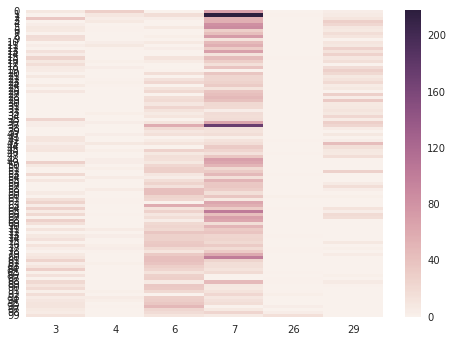

In [1016]:
sns.heatmap(df_g[[3,4,6,7,26,29]],linewidths=0)

In [1067]:
from sklearn.cross_validation import train_test_split

#lrc_g = sklearn.ensemble.RandomForestRegressor(n_estimators=5000)
lrc_g = LinearRegression(fit_intercept=True, copy_X=True)
X_g = df_g[[3,4,6,7,26,29]].values
Y_g = df_g['Avg'].values

# split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_g, Y_g, test_size=0.33, random_state=42)

lrc_g.fit(X_train, Y_train)
y_predict = lrc_g.predict(X_test)
print lrc_g.score(X_test, Y_test)

0.675505791358


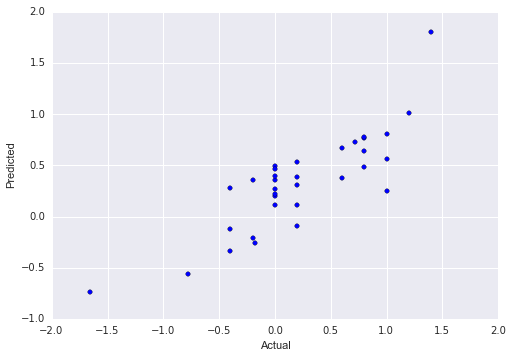

In [1068]:
plt.scatter(Y_test,y_predict);plt.xlabel('Actual');plt.ylabel('Predicted')

## Classify all blocked comments in corpus

In [1026]:
backer_comments_grouped_copy = backer_comments_grouped.copy(deep=True)

In [1027]:
backer_comments_grouped_copy.head(2)

comment       date  project_id
0  as one of the biggest fans of the game tetris ... 2014-09-30      182943
1  got it! (20 nov) thanks. can't wait to experim... 2014-11-30      182943

In [1060]:
inferences = alphalda.inference(alphacorp)[0]
df_inference = pd.DataFrame(inferences)

In [1064]:
df_inference_total = pd.concat([df_inference, backer_comments_grouped_copy],axis=1)

In [1066]:
df_inference_total.shape

(17824, 33)

In [ ]:
lrc_g.

In [1072]:
### use linear regressor to map each month to a sentiment value
X_g = df_inference_total[[3,4,6,7,26,29]].values
predicted_sentiments = lrc_g.predict(X_g)
df_inference_total['sentiment'] = predicted_sentiments

In [1076]:
df_inference_total.sort('sentiment',ascending=True).head(2)

0          1          2           3           4         5  \
842   0.033333   3.467283   0.033333  236.489611  159.677972  1.325942   
7039  0.033333  61.890216  95.649958   68.566603   39.883118  1.164671   

              6            7         8          9    ...            24  \
842   75.884989  1061.751259  0.033333  15.596535    ...      0.033333   
7039   0.033333  1600.909016  0.033333   0.033333    ...      5.516294   

              25         26          27        28           29  \
842   169.046774   0.033333  373.237623  0.033333  1709.943387   
7039    0.033333  12.588769    4.367049  5.206971   535.359798   

                                                comment       date  \
842   it was "jamming" a lot today, but i think i kn... 2013-11-30   
7039  in france, still waiting for tracking number/s... 2013-10-31   

      project_id  sentiment  
842    101767263 -27.036652  
7039   842797490 -16.173275  

[2 rows x 34 columns]

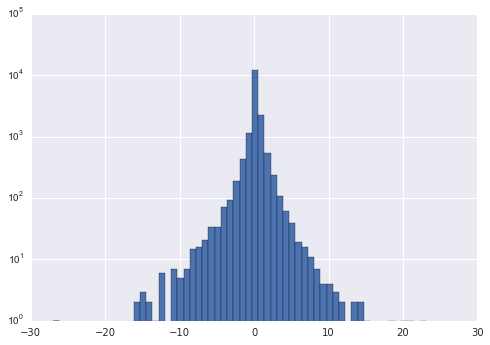

In [1096]:
plt.hist(predicted_sentiments,bins=60,log=True);

# Try to classify based on project features

In [242]:
# load project features
all_data = pickle.load(open('data/all_data_tech.p','rb'))

In [1094]:
all_data_sentiments = pd.merge(all_data, df_inference_total[['comment','date','project_id','sentiment']],on='project_id',how='inner')

In [1119]:
# compute date from start of project
start_date = all_data_sentiments[['project_id','date']].groupby('project_id').agg(min).reset_index().rename(columns={'date':'start'})
end_date = all_data_sentiments[['project_id','date']].groupby('project_id').agg(max).reset_index().rename(columns={'date':'end'})

all_data_sentiments_date = pd.merge(all_data_sentiments, start_date, on='project_id',how='inner')
all_data_sentiments_date = pd.merge(all_data_sentiments_date, end_date, on='project_id', how='inner')

all_data_sentiments_date['duration'] = all_data_sentiments_date['end'] - all_data_sentiments_date['start']
all_data_sentiments_date['date_from_start'] = all_data_sentiments_date['date'] - all_data_sentiments_date['start']
all_data_sentiments_date['date_from_end'] = all_data_sentiments_date['end'] - all_data_sentiments_date['date']

In [1237]:
pickle.dump(all_data_sentiments_date,open('data/pooled_lda_all_data_tech.p','wb'))

In [24]:
all_data_sentiments_date = pickle.load(open('data/pooled_lda_all_data_tech.p','rb'))
# add in sentiment normalized by word count
def word_count(comment):
    return len(word_tokenize(comment))
all_data_sentiments_date['word_count'] = all_data_sentiments_date['comment'].apply(word_count)

In [25]:
all_data_sentiments_date['normalized_sentiment'] = all_data_sentiments_date['sentiment'] / all_data_sentiments_date['word_count']

(-4, 9)

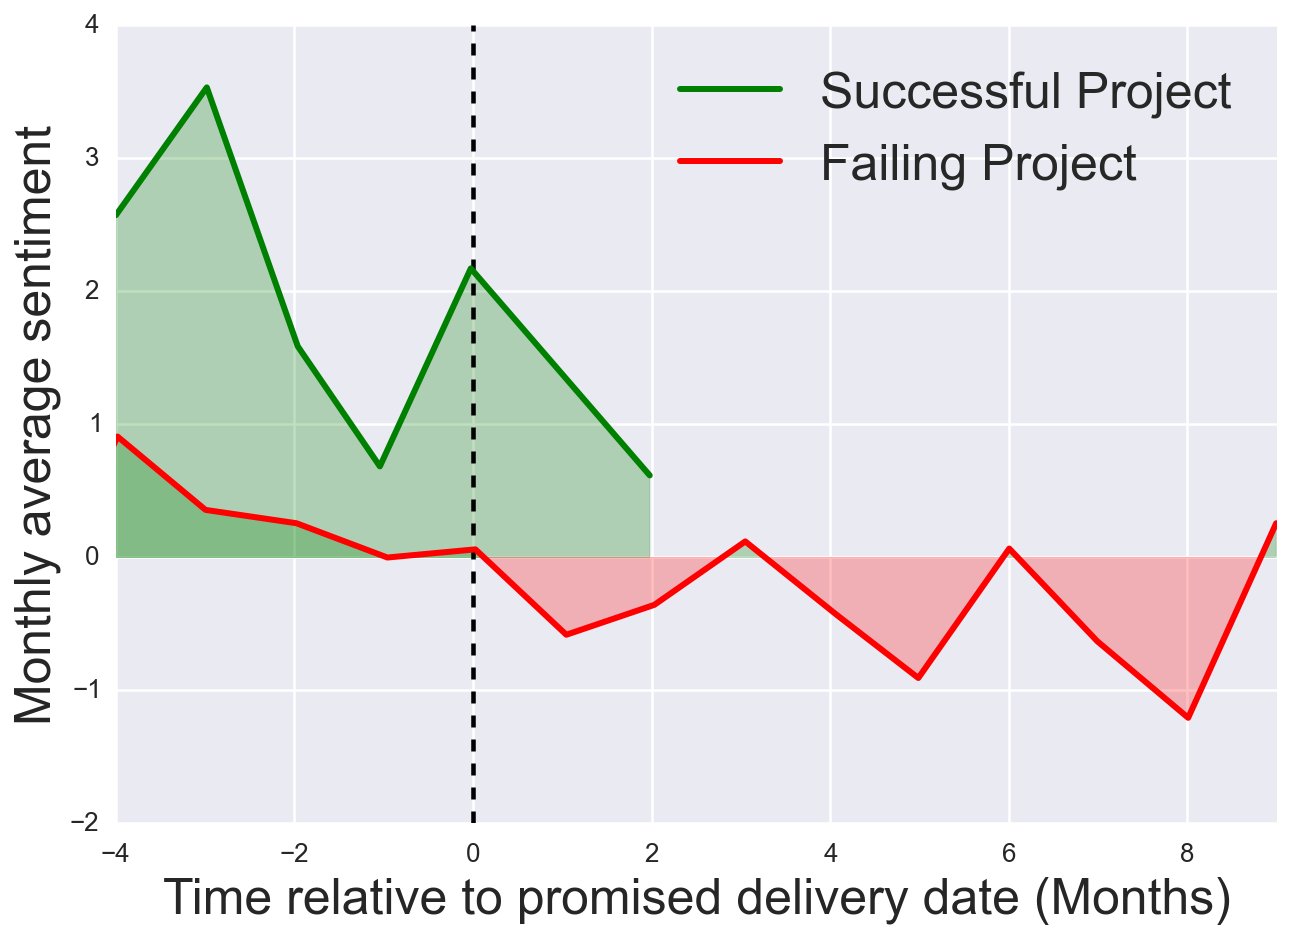

In [614]:
one_month = pd.tslib.Timedelta(1,"M")
good_project = ads_0[ads_0['project_id']==1650426305].sort('date',ascending=True)
bad_project = ads_0[ads_0['project_id']==685662565].sort('date',ascending=True)
plt.plot(good_project['date_from_start']/one_month-4, good_project['sentiment'],c='g',label='Successful Project',linewidth=3)
ax1 = plt.gca()
ax1.fill_between(good_project['date_from_start']/one_month-4, good_project['sentiment'],alpha=0.25,color='g')
plt.plot(bad_project['date_from_start']/one_month-5, bad_project['sentiment'],c='r',label='Failing Project',linewidth=3)

x = bad_project['date_from_start'].values/one_month-5
y = bad_project['sentiment']
xi = np.linspace(x[0],x[-1],1e3)

yi = np.interp(xi, x, y)
ax1.fill_between(xi, yi, where=(yi>=0),color='g',alpha=0.25)
ax1.fill_between(xi, yi, where=(yi<=0),color='r',alpha=0.25)
ax1.grid(True)
plt.vlines(0,-2,4,linestyles='--')
plt.xlabel('Time relative to promised delivery date (Months)',fontsize=25);
plt.ylabel('Monthly average sentiment',fontsize=25);
plt.legend(fontsize=25)
plt.xlim([-4,9])

In [ ]:
510-859-7748

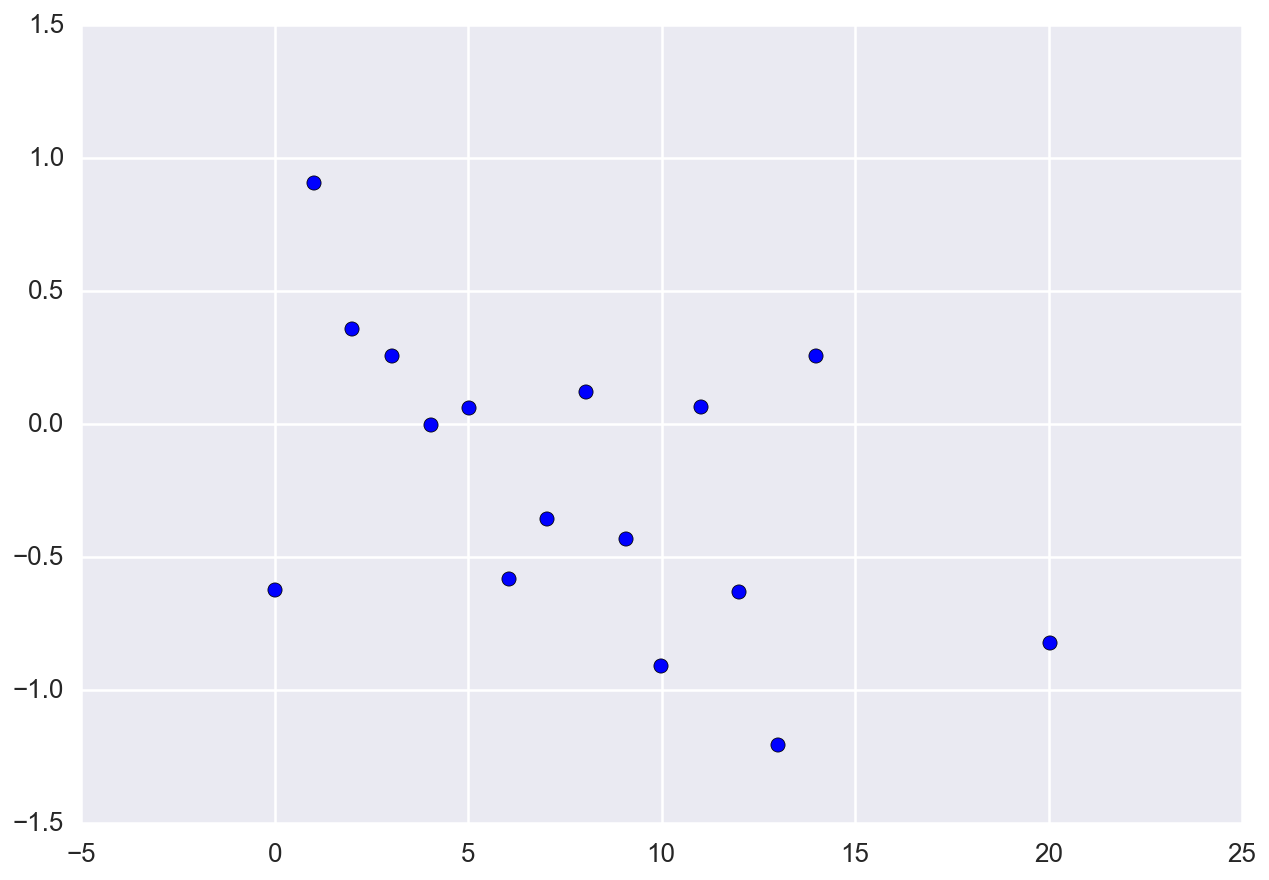

In [417]:
## FINSIX sentiment
d = all_data_sentiments_date[all_data_sentiments_date['project_id']==685662565]
plt.scatter(d['date_from_start']/pd.tslib.Timedelta(1,"M"), d['sentiment'], s=50)

In [412]:
sns.set_style("darkgrid")
sns.set_context("talk")
sns.set_axes_style({

In [36]:
#all_data_sentiments_date.sort('normalized_sentiment',ascending=True).iloc[4]['comment']

In [5]:
d = all_data_sentiments_date.groupby('project_id').agg(np.mean).reset_index()[['project_id','sentiment']]
dm = d[d['sentiment'] > 0]

In [6]:
dm.sort('sentiment',ascending=False).head(5)

project_id  sentiment
2490  2029044377   9.672964
1779  1422063641   5.575935
2107  1679969081   5.499596
1023   823124401   5.132445
2096  1671116914   4.779855

In [7]:
ts = pd.tslib.Timedelta(1,'M')

In [123]:
ads = all_data_sentiments_date.copy(deep=True)
ads['d_from_s'] = ads['date_from_start']/pd.tslib.Timedelta(1,"M")
ads[(ads['d_from_s']>10) & (ads['sentiment'] > 6)]

project_id  log_backed  log_created  log_comments  log_backers  \
1154   1650426305   -0.655342    -0.548694      1.116249    -0.254350   
12854   469832614   -1.252439    -0.548694      1.622483     1.460776   
14819  1636168806   -0.058246    -0.548694      1.087201     2.260390   
15398   868645767   -0.058246    -0.548694      0.878642     1.019482   

       log_pledged  log_goal  technology  technology/3d printing  \
1154     10.596960 -0.007755           0                       0   
12854    12.578966  1.018057           0                       0   
14819    12.810932  0.344117           0                       0   
15398    11.722668  1.400430           0                       0   

       technology/apps    ...           date  sentiment      start        end  \
1154                 0    ...     2015-12-31   8.544563 2014-11-30 2015-12-31   
12854                0    ...     2015-05-31   6.541740 2013-10-31 2015-12-31   
14819                0    ...     2015-12-31  11.606283 2014-11-30 2015-12-31   
15398                0    ...     2015-12-31   7.010030 2014-11-30 2015-12-31   

       duration  date_from_start  date_from_end  word_count  \
1154   396 days         396 days         0 days        8588   
12854  791 days         577 days       214 days        6625   
14819  396 days         396 days         0 days       19030   
15398  396 days         396 days         0 days        2149   

       normalized_sentiment   d_from_s  
1154               0.000995  13.010534  
12854              0.000987  18.957268  
14819              0.000610  13.010534  
15398              0.003262  13.010534  

[4 rows x 34 columns]

In [335]:
end_of_year

Timestamp('2015-12-31 00:00:00')

In [336]:
eoy = pd.Timestamp('2015-12-31 00:00:00')

In [153]:
end_of_year = ads[(ads['d_from_s']>10) & (ads['sentiment'] > 6)].iloc[0]['date']

In [156]:
ads_0[(ads_0['d_from_s']>10) & (ads_0['sentiment']>5)]

project_id  log_backed  log_created  log_comments  log_backers  \
12854   469832614   -1.252439    -0.548694      1.622483     1.460776   

       log_pledged  log_goal  technology  technology/3d printing  \
12854    12.578966  1.018057           0                       0   

       technology/apps    ...           date  sentiment      start        end  \
12854                0    ...     2015-05-31    6.54174 2013-10-31 2015-12-31   

       duration  date_from_start  date_from_end  word_count  \
12854  791 days         577 days       214 days        6625   

       normalized_sentiment   d_from_s  
12854              0.000987  18.957268  

[1 rows x 34 columns]

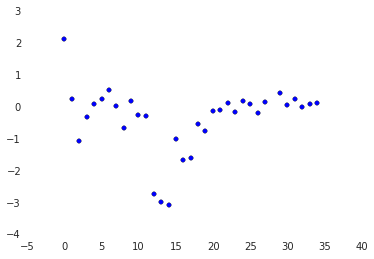

In [281]:
d = ads_0[ads_0['project_id']==1278963543] # stoneteather - somewhat of a failure (added features + delays)
plt.scatter(d['d_from_s'],d['sentiment'])

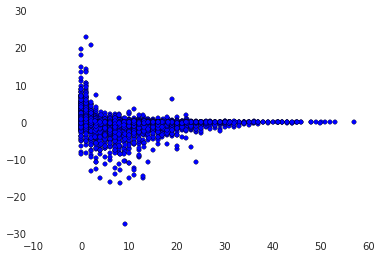

In [155]:
ads_0 = ads[ads['date'] != end_of_year]
plt.scatter(ads_0['d_from_s'],ads_0['sentiment'])

In [140]:
d= pickle.load(open('data/2015_06_06_comments_db.p','rb'))

In [145]:
from dateutil import parser

In [161]:
dp.head(2)

project_id  log_backed  log_created  log_comments  log_backers  \
12835   469832614   -1.252439    -0.548694      1.622483     1.460776   
12836   469832614   -1.252439    -0.548694      1.622483     1.460776   

       log_pledged  log_goal  technology  technology/3d printing  \
12835    12.578966  1.018057           0                       0   
12836    12.578966  1.018057           0                       0   

       technology/apps    ...          date  sentiment      start        end  \
12835                0    ...    2013-10-31   2.128301 2013-10-31 2015-12-31   
12836                0    ...    2013-11-30   1.363143 2013-10-31 2015-12-31   

       duration  date_from_start  date_from_end  word_count  \
12835  791 days           0 days       791 days        2553   
12836  791 days          30 days       761 days        8585   

       normalized_sentiment  d_from_s  
12835              0.000834  0.000000  
12836              0.000159  0.985647  

[2 rows x 34 columns]

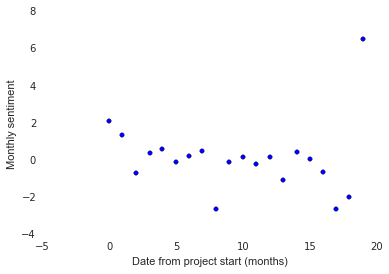

In [160]:
dp = ads_0[ads_0['project_id']==469832614  ]
plt.scatter(dp['d_from_s'],dp['sentiment']);
plt.xlabel('Date from project start (months)');plt.ylabel('Monthly sentiment');

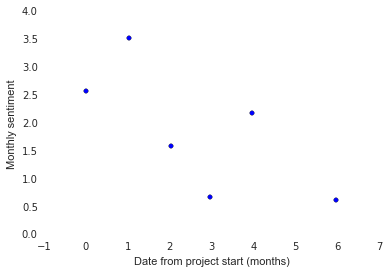

In [159]:
dp = ads_0[ads_0['project_id']==1650426305  ]
plt.scatter(dp['d_from_s'],dp['sentiment']);
plt.xlabel('Date from project start (months)');plt.ylabel('Monthly sentiment');

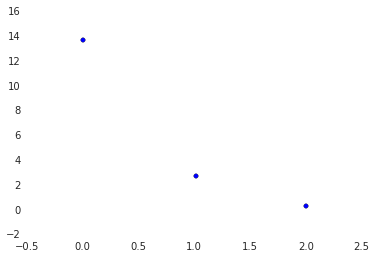

In [122]:
dp = all_data_sentiments_date[all_data_sentiments_date['project_id']==1422063641]
plt.scatter(dp['date_from_start'].apply(lambda x:x/ts),dp['sentiment'])

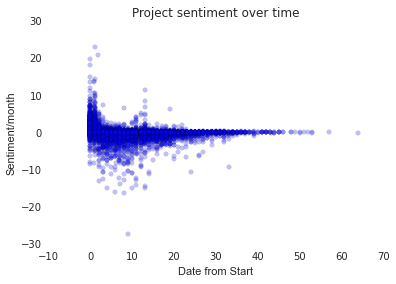

In [75]:
# comment sentiment vs time from start
plt.scatter(all_data_sentiments_date['date_from_start'].apply(lambda x:x/ts),all_data_sentiments_date['sentiment'],alpha=0.25);
plt.xlabel('Date from Start');plt.ylabel('Sentiment/month');plt.title('Project sentiment over time')

In [ ]:
def get_last_sentiment(df_group):
    
all_data_sentiments_date.groupby('project_id')

In [236]:
# Filter projects:
# remove comments 6 months before last comment and within 2 months of first comment
d_after_start = pd.tslib.Timedelta(3,'M')
d_before_end = pd.tslib.Timedelta(6,'M')

all_data_filtered = all_data_sentiments_date[all_data_sentiments_date['date_from_start'] > d_after_start]
all_data_filtered = all_data_filtered[all_data_filtered['date_from_end'] <= d_before_end]

In [49]:
all_data_sentiments_date.shape

(17756, 33)

In [50]:
all_data_filtered.shape

(3457, 33)

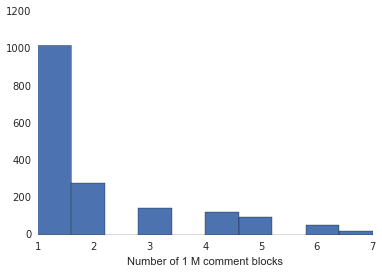

In [57]:
plt.hist(all_data_filtered.groupby('project_id')['technology'].count().values);
plt.xlabel('Number of 1 M comment blocks')

## Visualize positive vs negative comments 

In [777]:
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import sklearn.manifold

X_df = all_data_sentiments_date.copy(deep=True).drop(labels='end',axis=1);
#X_df = X_df[X_df['date'] != end_of_year] # remove end-of-year anamoly

#X_df = pd.merge(X_df, X_df.groupby('project_id').aggregate(max).reset_index()[['project_id', 'date']].rename(columns={'date':'end'}),on='project_id',how='inner')
#X_df['date_from_end'] = X_df['end'] - X_df['date']

# drop comments less than 2 months from start of project or more than 8 months from end of project
#one_month = pd.tslib.Timedelta(1,"M")
#X_df = X_df[(X_df['date_from_start']/one_month > 1.5) & (X_df['date_from_end'] > 8)]
#X_df['duration'] = X_df['end'] - X_df['start']
Xv = X_df.drop(labels=['project_id','comment','date','sentiment','normalized_sentiment', 'start','duration','date_from_start','date_from_end','word_count'],axis=1)
X = Xv.values

Y = X_df['sentiment'].values

## Develope score for projects

In [778]:
# normalize sentiment per month
X_df_min_sent = X_df[['project_id','sentiment']].copy(deep=True)
X_df_min_sent = X_df_min_sent.groupby('project_id').agg(min).reset_index()
X_df_min_sent.rename(columns={'sentiment':'min_sentiment'},inplace=True)

Xdata = pd.merge(X_df_min_sent,all_data,on='project_id',how='inner')

X = Xdata.drop(labels=['project_id','min_sentiment'],axis=1)
X = X.drop(labels='log_comments',axis=1)
Yc = Xdata['min_sentiment'].values # continuous variable
# merge with project features
#all_data_copy = X_df.copy(deep=True)
#X_df_min_sent = pd.merge(X_df_min_sent, all_data_copy, on='project_id',how='inner')
#X_df_min_sent.rename(columns={'sentiment':'min_sentiment'},inplace=True)

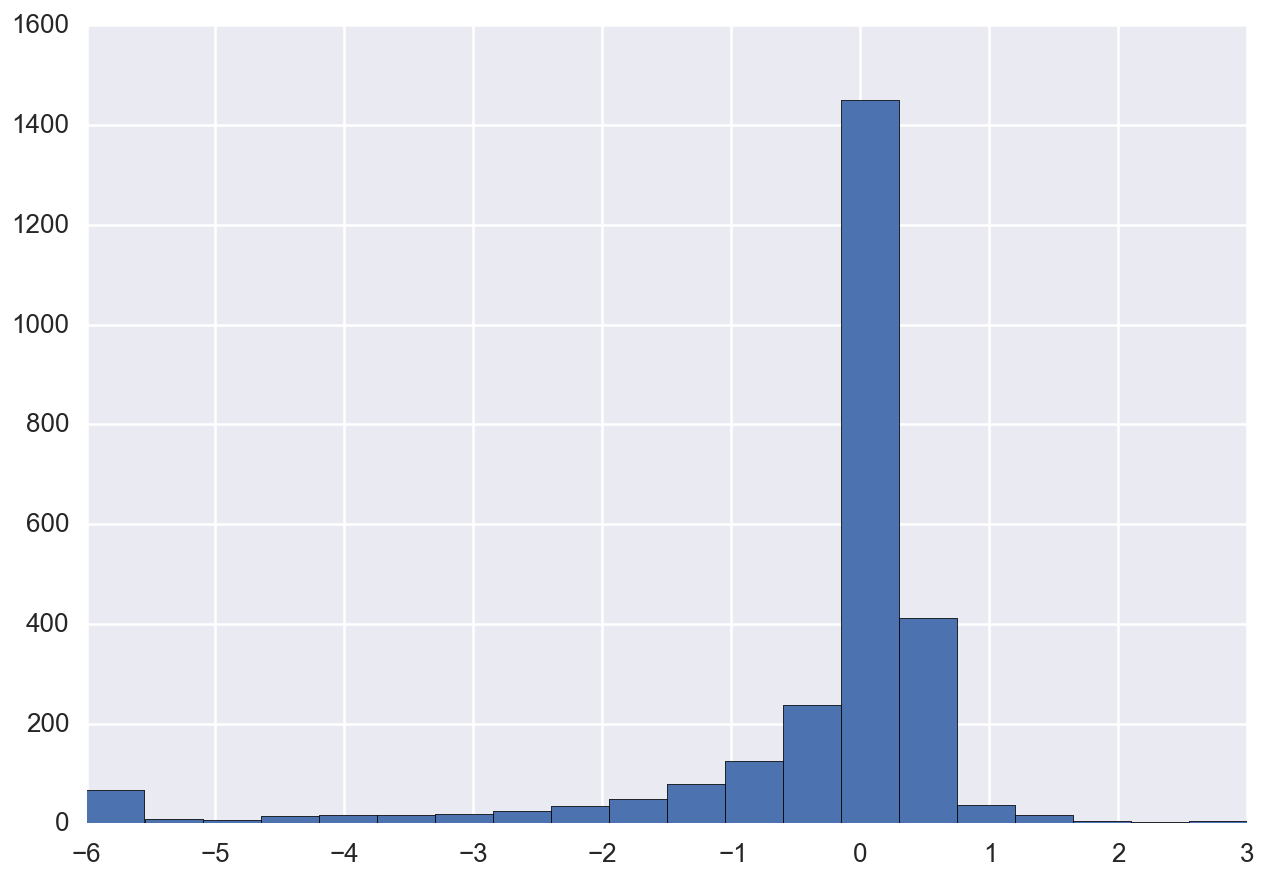

In [740]:
plt.hist(Xdata['min_sentiment'].apply(lambda x:max(min(x,3),-6)),bins=20);

In [734]:
tsne = sklearn.manifold.TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

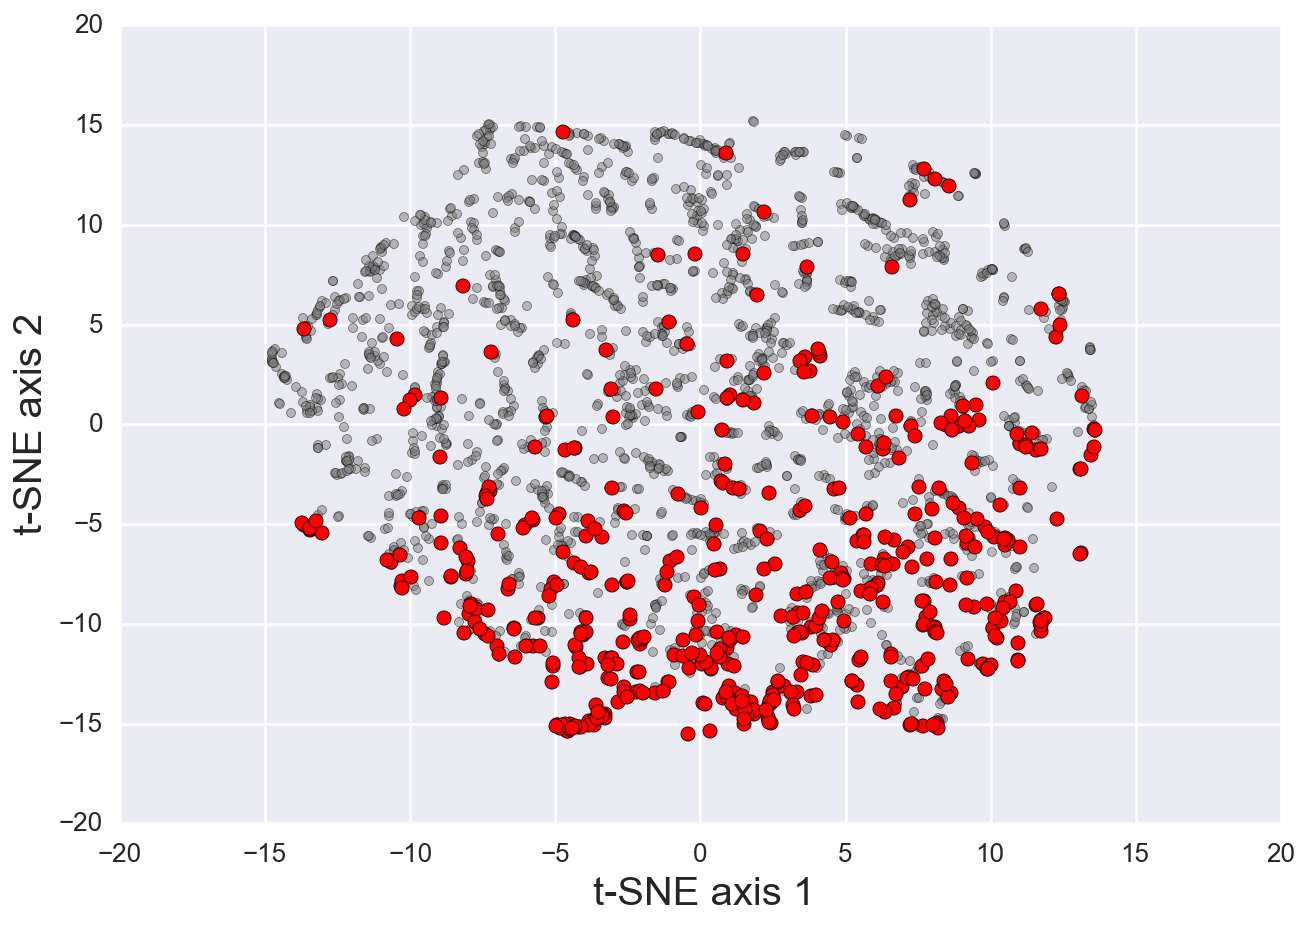

In [779]:
# now visualize by min sentiment only
d = pd.DataFrame()
d['y'] = Yc
d['X_red_0'] = X_tsne[:,0]
d['X_red_1'] = X_tsne[:,1]

plt.scatter(X_tsne[:,0], X_tsne[:,1], c='grey', alpha=0.5)
d_worst = d[d['y'] <-0.5]
plt.scatter(d_worst['X_red_0'], d_worst['X_red_1'],s=50,c='r',label='Failed')
d_best = d[d['y'] > 0.5]
#plt.scatter(d_best['X_red_0'], d_best['X_red_1'],s=50,c='g',label='Very Successful')
plt.xlabel('t-SNE axis 1',fontsize=20);
plt.ylabel('t-SNE axis 2',fontsize=20);
#plt.legend(fontsize=20)

## Classify based on min-sentiment metric

In [780]:
cutoff = -0.5
Y_vals = (Xdata['min_sentiment'] < cutoff).values # True -> 1 (failed projects)
Y = map(lambda x:int(x), Y_vals)

# split into train/test sets
X_train0, X_test, Y_train0, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# downsample training set
df_train = pd.DataFrame(X_train0)
df_train['Y'] = Y_train0
df_train_neg = df_train[df_train['Y'] == 1]
df_train_pos_full = df_train[df_train['Y'] == 0]
df_train_pos = df_train_pos_full.iloc[np.random.choice(range(len(df_train_pos_full)), len(df_train_neg), replace=False)]

df_train = pd.concat([df_train_neg, df_train_pos])
X_train = df_train.drop(labels='Y',axis=1).values
Y_train = df_train['Y'].values

In [330]:
Xdata.head(2)

project_id  min_sentiment  log_backed  log_created  log_comments  \
0      182943       0.269625    0.423824    -0.548694     -0.541863   
1      422207       0.102857   -0.655342     4.307481      1.007167   

   log_backers  log_pledged  log_goal  technology  technology/3d printing  \
0    -0.739897     7.751561 -1.118400           1                       0   
1    -0.061835     8.952605 -1.069694           0                       0   

        ...        technology/flight  technology/gadgets  technology/hardware  \
0       ...                        0                   0                    0   
1       ...                        0                   0                    1   

   technology/makerspaces  technology/robots  technology/software  \
0                       0                  0                    0   
1                       0                  0                    0   

   technology/sound  technology/space exploration  technology/wearables  \
0                 0                             0                     0   
1                 0                             0                     0   

   technology/web  
0               0  
1               0  

[2 rows x 24 columns]

### Write to files

In [331]:
### Write min sentiment data
pickle.dump(Xdata,open('data/min_sentiment_tech.p','wb'))

In [333]:
### sentiment by month 
pickle.dump(X_df,open('data/sentiment_tech_06_21.p','wb'))

In [338]:
X_df.head(2)

project_id  log_backed  log_created  log_comments  log_backers  \
0  1842798593   -1.252439    -0.548694     -0.927679    -0.061835   
1   717118235    1.733045     2.428856      1.378449     1.034797   

   log_pledged  log_goal  technology  technology/3d printing  technology/apps  \
0     8.470521 -0.470500           0                       0                0   
1     9.995428 -0.944787           0                       0                0   

           ...           technology/web  \
0          ...                        1   
1          ...                        0   

                                             comment       date  sentiment  \
0  this is such a necessary tool. we really must ... 2013-11-30   0.126987   
1  i am so stoked to see how your interactive app... 2015-03-31   0.347788   

       start  duration  date_from_start  date_from_end  word_count  \
0 2013-11-30    0 days           0 days         0 days         243   
1 2015-03-31   61 days           0 days        61 days         846   

   normalized_sentiment  
0              0.000523  
1              0.000411  

[2 rows x 32 columns]

### Train classifier

In [296]:
from sklearn.ensemble import RandomForestClassifier

In [781]:
def train_and_test(clf, X_train, Y_train, X_test, Y_test):
    clf.fit(X_train, Y_train) 

    # make predictions
    Y_predict = clf.predict(X_test)
    accuracy = sklearn.metrics.accuracy_score(Y_test, Y_predict)
    precision = sklearn.metrics.precision_score(Y_test, Y_predict)
    recall = sklearn.metrics.recall_score(Y_test, Y_predict)
    F1 = sklearn.metrics.f1_score(Y_test, Y_predict)
#    F1 = 2*precision*recall/(precision+recall)
    print 'accuracy = %g, precision = %g, recall = %g, F1 = %g' % (accuracy, precision, recall, F1)    

In [782]:
np.sum(Y_test)/len(Y_test)

0.17667436489607391

In [784]:
2*0.177/(1 + 0.177)

0.3007646559048428

In [783]:
rfc = RandomForestClassifier(n_estimators=5000)
train_and_test(rfc, X_train, Y_train, X_test, Y_test)

accuracy = 0.73903, precision = 0.384858, recall = 0.797386, F1 = 0.519149


In [456]:
rfc.feature_importances_

array([ 0.10114542,  0.03529536,  0.27624447,  0.28203192,  0.16006147,
        0.01767985,  0.00807587,  0.00762326,  0.00601456,  0.00988057,
        0.00602606,  0.0034727 ,  0.00963456,  0.01917259,  0.00043515,
        0.00680683,  0.02122412,  0.01284811,  0.00125879,  0.01388587,
        0.00118247])

In [479]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize

In [485]:
# Learn to predict each class against the other
classifier = OneVsOneClassifier(RandomForestClassifier(n_estimators=5000))
y_score = classifier.fit(X_train, Y_train).decision_function(X_test)

In [664]:
n_samps = 20
d = Xdata.iloc[np.random.choice(range(Xdata.shape[0]), n_samps, replace=False)][['project_id', 'min_sentiment']]
proj = pickle.load(open('data/projects_tech_2015_06_04.p','rb'))
d['url'] = d['project_id'].apply(lambda x: proj[x]['urls']['web']['project'])

In [719]:
d.loc[d.index[19],'label']=1

In [723]:
d[(d['min_sentiment']<=cutoff) & (d['label']<0)]

project_id  min_sentiment  \
348   272279304      -2.871556   
945   760657908      -3.431261   
343   268800968      -1.564530   
557   432703172     -10.543659   

                                                   url label  
348  https://www.kickstarter.com/projects/89577853/...    -2  
945  https://www.kickstarter.com/projects/devium/da...    -2  
343  https://www.kickstarter.com/projects/tabuprodu...    -1  
557  https://www.kickstarter.com/projects/radiate/r...    -2

In [731]:
d[(d['min_sentiment']<=cutoff) & (d['label']>=0)]

project_id  min_sentiment  \
1293  1032966918      -9.820858   

                                                    url label  
1293  https://www.kickstarter.com/projects/davefoste...     0

In [725]:
d[(d['min_sentiment']>cutoff) & (d['label']<0)]

project_id  min_sentiment  \
1734  1385354933      -0.354722   
1203   954675231       0.029909   
1472  1169394911       0.191238   

                                                    url label  
1734  https://www.kickstarter.com/projects/hunterlee...    -2  
1203  https://www.kickstarter.com/projects/mattbshee...    -2  
1472  https://www.kickstarter.com/projects/171832423...    -2

In [726]:
d[(d['min_sentiment']>cutoff) & (d['label']>=0)]

project_id  min_sentiment  \
914    724813052       0.266976   
582    450268797       0.230498   
2191  1761679524      -0.230025   
1913  1523215551       0.221461   
1414  1125513475       0.257064   
1400  1110939959      -0.048104   
1093   871423940       0.174307   
2595  2125527819      -0.069426   
2317  1867880513      -0.019885   
1711  1370072152       0.337239   
7        5099660       0.337447   
2250  1813078228       0.257064   

                                                    url label  
914   https://www.kickstarter.com/projects/428897786...     0  
582   https://www.kickstarter.com/projects/mjtamlyn/...     2  
2191  https://www.kickstarter.com/projects/mipowusa/...     1  
1913  https://www.kickstarter.com/projects/895719238...     1  
1414  https://www.kickstarter.com/projects/ciseco/pi...     2  
1400  https://www.kickstarter.com/projects/132031050...     0  
1093  https://www.kickstarter.com/projects/117424136...     0  
2595  https://www.kickstarter.com/projects/blueeagle...     1  
2317  https://www.kickstarter.com/projects/104000578...     0  
1711  https://www.kickstarter.com/projects/172204344...     2  
7     https://www.kickstarter.com/projects/wondercho...     1  
2250  https://www.kickstarter.com/projects/131582117...     1

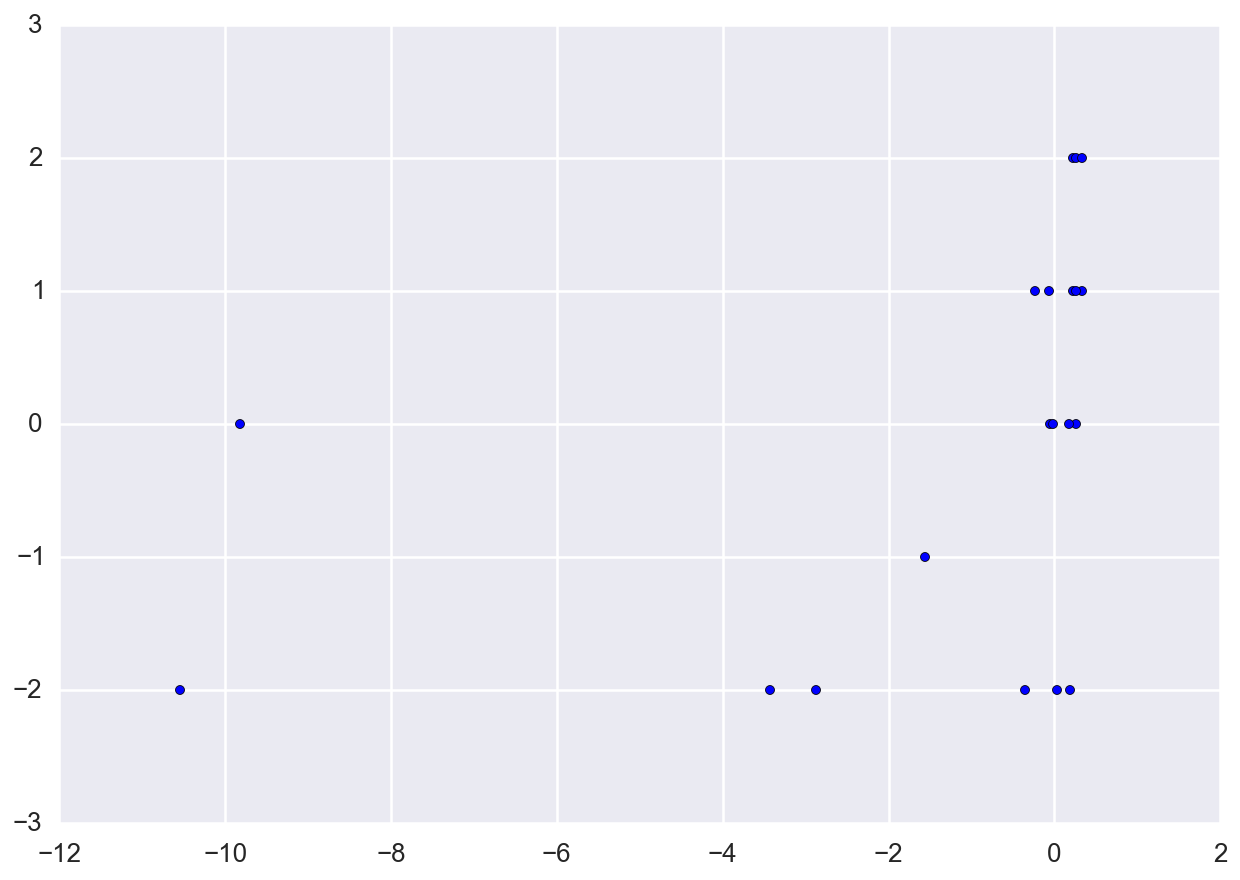

In [732]:
plt.scatter(d['min_sentiment'],d['label'])

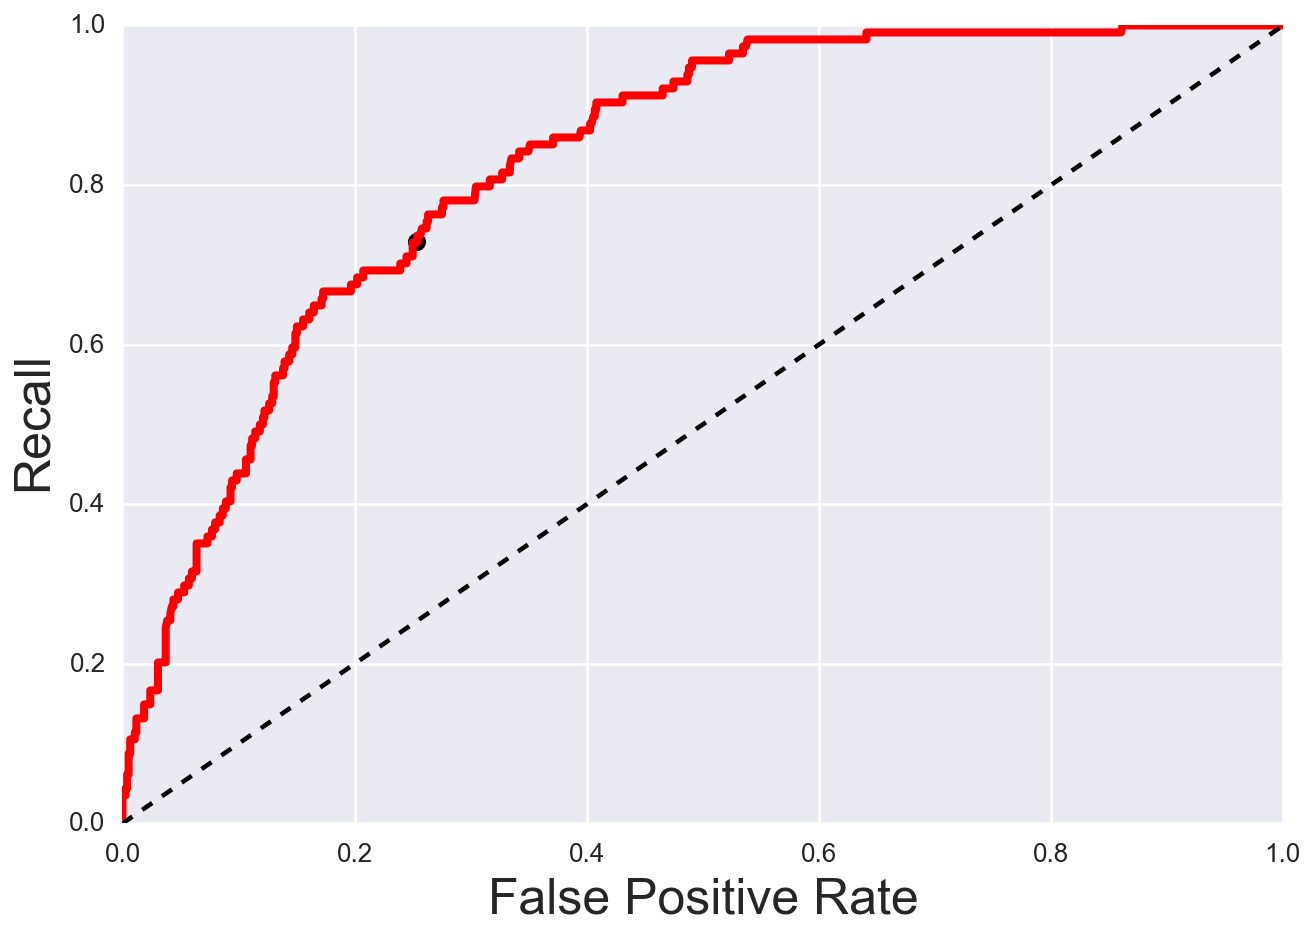

In [514]:
# Compute ROC curve and ROC area for each class
fpr, tpr, thresholds = roc_curve(Y_test, y_score[:,1], pos_label=1)
plt.plot(fpr,tpr,linewidth=4,color='r')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('False Positive Rate',fontsize=25); plt.ylabel('Recall',fontsize=25)
plt.scatter(fpr[259],tpr[259],color='k',s=75)
plt.xlim([0,1]);plt.ylim([0,1]);

# Classify based in initial sentiment as another feature

In [761]:
initial_data = all_data_sentiments_date[all_data_sentiments_date['date_from_start'] <= pd.tslib.Timedelta(2,'M')]
initial_data = initial_data.groupby('project_id')['sentiment'].agg(min).reset_index()
initial_data.rename(columns={'sentiment':'initial_sentiment'}, inplace=True)

X_df_min_sent = X_df[['project_id','sentiment']].copy(deep=True)
X_df_min_sent = X_df_min_sent.groupby('project_id').agg(min).reset_index()
X_df_min_sent.rename(columns={'sentiment':'min_sentiment'},inplace=True)

Xdata = pd.merge(X_df_min_sent,all_data,on='project_id',how='inner')
Xdata_2 = pd.merge(Xdata, initial_data, on='project_id', how='inner')

X = Xdata_2.drop(labels=['project_id','min_sentiment'],axis=1)
X = X.drop(labels='log_comments',axis=1)
Yc = Xdata['min_sentiment'].values # continuous variable

In [763]:
tsne = sklearn.manifold.TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

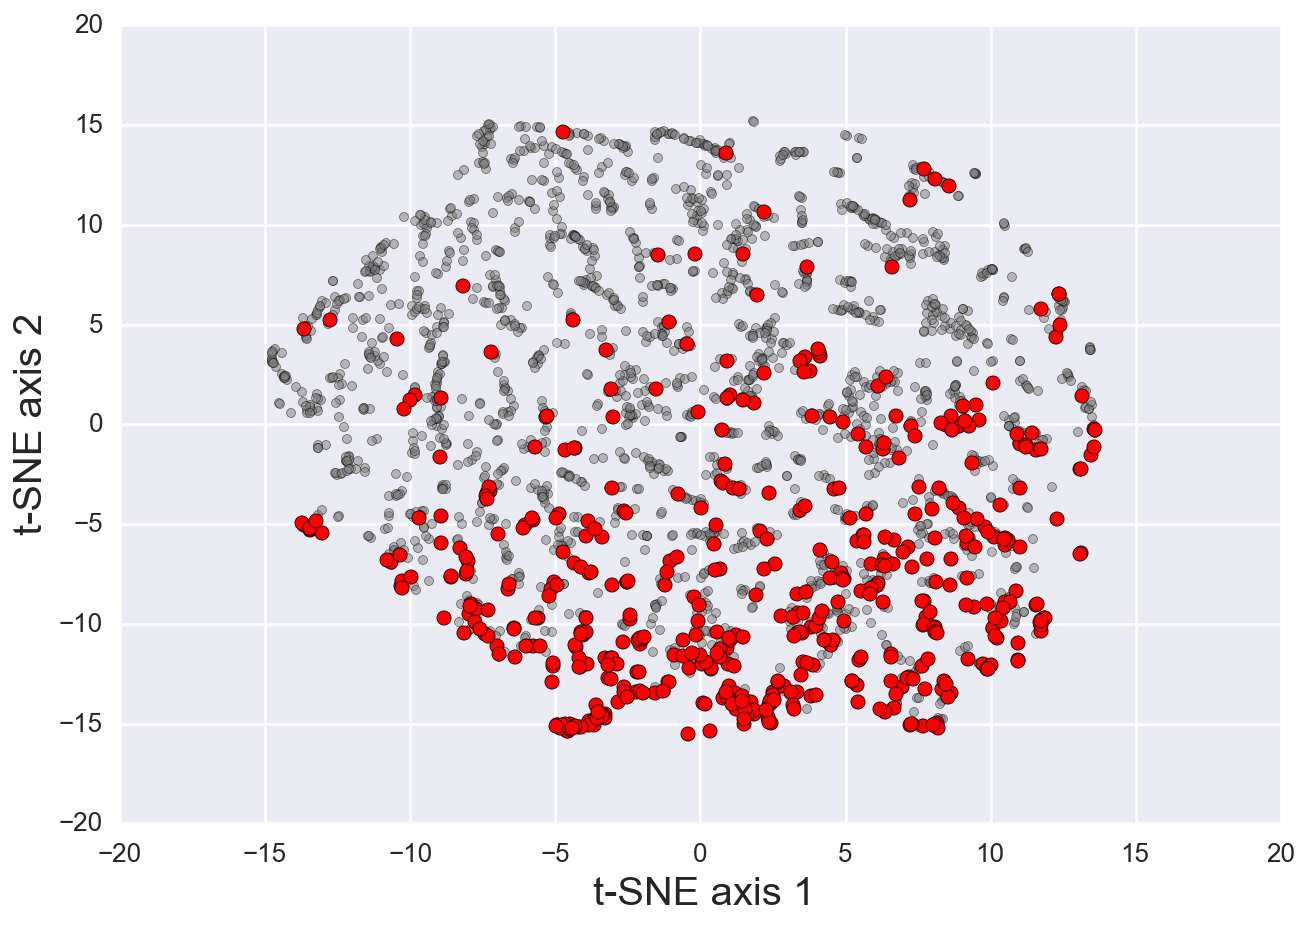

In [773]:
# now visualize by min sentiment only
d = pd.DataFrame()
d['y'] = Yc
d['X_red_0'] = X_tsne[:,0]
d['X_red_1'] = X_tsne[:,1]

plt.scatter(X_tsne[:,0], X_tsne[:,1], c='grey', alpha=0.5)
d_worst = d[d['y'] <-0.5]
plt.scatter(d_worst['X_red_0'], d_worst['X_red_1'],s=50,c='r',label='Failed')
d_best = d[d['y'] > 0.5]
#plt.scatter(d_best['X_red_0'], d_best['X_red_1'],s=50,c='g',label='Very Successful')
plt.xlabel('t-SNE axis 1',fontsize=20);
plt.ylabel('t-SNE axis 2',fontsize=20);
#plt.legend(fontsize=20)

In [771]:
cutoff = -0.5
Y_vals = (Xdata['min_sentiment'] < cutoff).values # True -> 1 (failed projects)
Y = map(lambda x:int(x), Y_vals)

# split into train/test sets
X_train0, X_test, Y_train0, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# downsample training set
df_train = pd.DataFrame(X_train0)
df_train['Y'] = Y_train0
df_train_neg = df_train[df_train['Y'] == 1]
df_train_pos_full = df_train[df_train['Y'] == 0]
df_train_pos = df_train_pos_full.iloc[np.random.choice(range(len(df_train_pos_full)), len(df_train_neg), replace=False)]

df_train = pd.concat([df_train_neg, df_train_pos])
X_train = df_train.drop(labels='Y',axis=1).values
Y_train = df_train['Y'].values

In [772]:
rfc = RandomForestClassifier(n_estimators=5000)
train_and_test(rfc, X_train, Y_train, X_test, Y_test)

accuracy = 0.795612, precision = 0.457143, recall = 0.836601, F1 = 0.591224


In [774]:
rfc.feature_importances_

array([ 0.06846516,  0.02240475,  0.25175055,  0.23341091,  0.1176717 ,
        0.01084702,  0.00612059,  0.00945333,  0.00370433,  0.00487686,
        0.00282619,  0.00164484,  0.00701676,  0.01605165,  0.00144764,
        0.00519939,  0.01097664,  0.00585832,  0.00410163,  0.00862954,
        0.0015136 ,  0.20602861])

In [770]:
X.head(1)

log_backed  log_created  log_backers  log_pledged  log_goal  technology  \
0    0.423824    -0.548694    -0.739897     7.751561   -1.1184           1   

   technology/3d printing  technology/apps  technology/camera equipment  \
0                       0                0                            0   

   technology/diy electronics        ...          technology/gadgets  \
0                           0        ...                           0   

   technology/hardware  technology/makerspaces  technology/robots  \
0                    0                       0                  0   

   technology/software  technology/sound  technology/space exploration  \
0                    0                 0                             0   

   technology/wearables  technology/web  initial_sentiment  
0                     0               0            0.84509  

[1 rows x 22 columns]

In [775]:
sum(Y_test)/len(Y_test)

0.1766743648960739

In [776]:
2*0.177/(1+0.177)

0.3007646559048428

## END

In [504]:
tpr[259]

0.72807017543859653

In [499]:
[ii for ii in range(len(thresholds)) if thresholds[ii]<0.5][0]

259

In [ ]:
df['FMetric_Outlook'][name]

In [355]:
sum(Y) / len(Y)

0.13719512195121952

In [356]:
2*0.137/(1+0.137) # best-case F1 for random classifier

0.24098504837291118

In [308]:
Xdata.head(2)

project_id  min_sentiment  log_backed  log_created  log_comments  \
0      182943       0.269625    0.423824    -0.548694     -0.541863   
1      422207       0.102857   -0.655342     4.307481      1.007167   

   log_backers  log_pledged  log_goal  technology  technology/3d printing  \
0    -0.739897     7.751561 -1.118400           1                       0   
1    -0.061835     8.952605 -1.069694           0                       0   

        ...        technology/flight  technology/gadgets  technology/hardware  \
0       ...                        0                   0                    0   
1       ...                        0                   0                    1   

   technology/makerspaces  technology/robots  technology/software  \
0                       0                  0                    0   
1                       0                  0                    0   

   technology/sound  technology/space exploration  technology/wearables  \
0                 0                             0                     0   
1                 0                             0                     0   

   technology/web  
0               0  
1               0  

[2 rows x 24 columns]

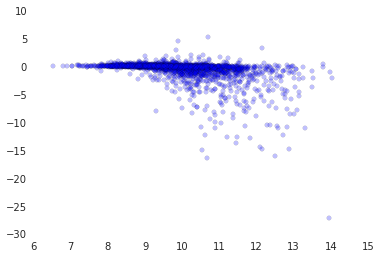

In [310]:
plt.scatter(Xdata['log_pledged'] - Xdata['log_goal'], Xdata['min_sentiment'],alpha=0.25)

## Output predicted project outcomes

In [532]:
all_data_tech_live = pickle.load(open('data/all_data_tech_live.p','rb'))

In [533]:
all_data_tech_live.head(2)

project_id  log_backed  log_created  log_comments  log_backers  \
0  1408128342   -1.252222    -0.548599     -1.538916    -2.268228   
1  1628477448    0.813036     2.428436      0.899760    -0.408677   

   log_pledged  log_goal  technology  technology/3d printing  technology/apps  \
0     5.081404 -0.273467           0                       0                1   
1     9.765145  0.143909           0                       0                0   

        ...        technology/flight  technology/gadgets  technology/hardware  \
0       ...                        0                   0                    0   
1       ...                        0                   0                    0   

   technology/makerspaces  technology/robots  technology/software  \
0                       0                  0                    0   
1                       0                  0                    0   

   technology/sound  technology/space exploration  technology/wearables  \
0                 0                             0                     0   
1                 0                             0                     0   

   technology/web  
0               0  
1               0  

[2 rows x 23 columns]

In [571]:
def rescale_pledged(row, mu_goal, sigma_goal):
    # pledged was not scaled/shifted
    pledged = np.exp(row['log_pledged']) - 1
    goal = np.exp(sigma_goal*row['log_goal'] + mu_goal) - 1
    
    if pledged < goal:
        return np.log(goal + 1) # return log goal, not scaled/shifted
    else:
        return row['log_pledged'] # keep number

In [590]:
X_live = all_data_tech_live.drop(labels=['project_id', 'log_comments'],axis=1)
X_live['log_goal'] = all_data_tech_live.apply(lambda x:rescale_pledged(x, mu['log_goal'], sigma['log_goal']),axis=1)
p_success = rfc.predict_proba(X_live)[:,0]

In [591]:
all_data_tech_live_with_probs = all_data_tech_live.copy(deep=True)
all_data_tech_live_with_probs['success_prob'] = p_success

In [592]:
all_data_tech_live_with_probs['success_prob'].median()

0.7576

In [578]:
# load mean and std from training set
import process_data
reload(process_data)

fname_tech = 'data/projects_tech_2015_06_04.p'
fname_tech_creator = 'data/creator_data_tech_06_09.p'

fname_tech_live = 'data/projects_tech_live_06_20.p'
fname_tech_creator_live = 'data/creator_data_tech_live_06_20.p'

df_training,mu,sigma = process_data.prepare_project_data(fname_tech,fname_tech_creator)

all_data_exp = all_data_tech_live_with_probs.copy()
all_data_exp['goal']    = np.exp(sigma['log_goal']   *all_data_exp['log_goal']    + mu['log_goal'])    - 1
all_data_exp['pledged'] = np.exp(all_data_exp['log_pledged']) - 1
all_data_exp_c = all_data_exp[all_data_exp['pledged'] >= all_data_exp['goal']]

In [586]:
X_live.head(2)

log_backed  log_created  log_backers  log_pledged  log_goal  technology  \
0   -1.252222    -0.548599    -2.268228     5.081404  8.517393           0   
1    0.813036     2.428436    -0.408677     9.765145  9.765145           0   

   technology/3d printing  technology/apps  technology/camera equipment  \
0                       0                1                            0   
1                       0                0                            1   

   technology/diy electronics       ...        technology/flight  \
0                           0       ...                        0   
1                           0       ...                        0   

   technology/gadgets  technology/hardware  technology/makerspaces  \
0                   0                    0                       0   
1                   0                    0                       0   

   technology/robots  technology/software  technology/sound  \
0                  0                    0                 0   
1                  0                    0                 0   

   technology/space exploration  technology/wearables  technology/web  
0                             0                     0               0  
1                             0                     0               0  

[2 rows x 21 columns]

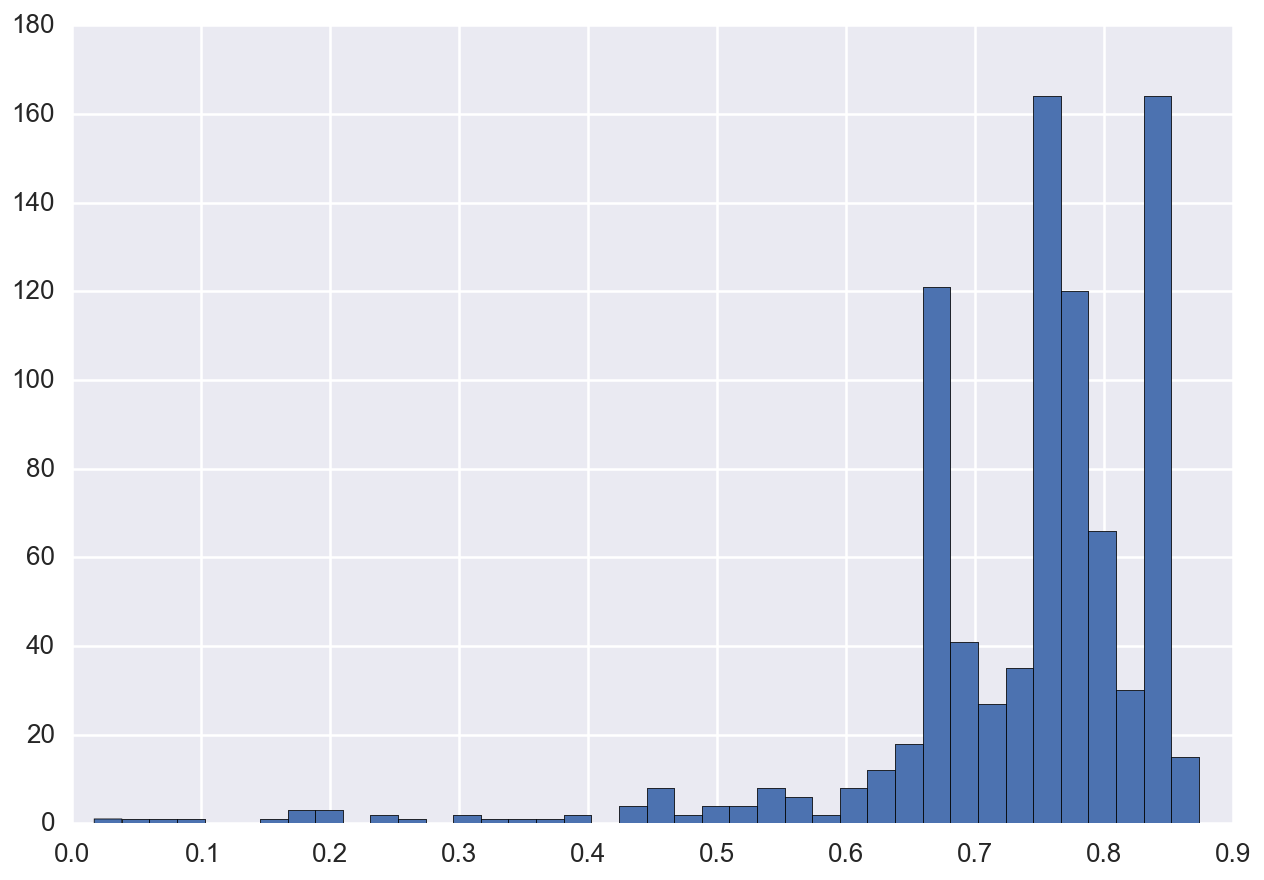

In [593]:
plt.hist(all_data_exp['success_prob'].values,bins=40);

In [473]:
a.head(2)

project_id  log_backed  log_created  log_comments  log_backers  \
0  1408128342   -0.466172    -0.359239     -0.466770     0.030122   
1  1628477448    2.880122     4.366170      3.731569     1.540916   

   log_pledged  log_goal  technology  technology/3d printing  technology/apps  \
0     5.081404 -0.732815           0                       0                1   
1     9.765145 -0.329248           0                       0                0   

       ...       technology/gadgets  technology/hardware  \
0      ...                        0                    0   
1      ...                        0                    0   

   technology/makerspaces  technology/robots  technology/software  \
0                       0                  0                    0   
1                       0                  0                    0   

   technology/sound  technology/space exploration  technology/wearables  \
0                 0                             0                     0   
1                 0                             0                     0   

   technology/web  success_prob  
0               0        0.9472  
1               0        0.5546  

[2 rows x 24 columns]

In [594]:
all_data_tech_live_with_probs_and_goals = pd.merge(all_data_tech_live_with_probs, all_data_exp[['project_id','pledged','goal']],how='inner',on='project_id')

In [595]:
all_data_tech_live_with_probs_and_goals.head(2)

project_id  log_backed  log_created  log_comments  log_backers  \
0  1408128342   -1.252222    -0.548599     -1.538916    -2.268228   
1  1628477448    0.813036     2.428436      0.899760    -0.408677   

   log_pledged  log_goal  technology  technology/3d printing  technology/apps  \
0     5.081404 -0.273467           0                       0                1   
1     9.765145  0.143909           0                       0                0   

   ...    technology/makerspaces  technology/robots  technology/software  \
0  ...                         0                  0                    0   
1  ...                         0                  0                    0   

   technology/sound  technology/space exploration  technology/wearables  \
0                 0                             0                     0   
1                 0                             0                     0   

   technology/web  success_prob  pledged   goal  
0               0        0.8326      160   5000  
1               0        0.7460    17415  10500  

[2 rows x 26 columns]

In [596]:
all_data_tech_live_with_probs_and_goals.shape

(880, 26)

In [597]:
pickle.dump(all_data_tech_live_with_probs_and_goals, open('data/all_data_tech_live_success_prob.p','wb'))

# Try regression

In [361]:
Yr = Xdata['min_sentiment']

# split into train/test sets
X_trainr, X_testr, Y_trainr, Y_testr = train_test_split(X, Yr, test_size=0.33, random_state=42)

In [363]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=5000)
train_and_test(rfr, X_trainr, Y_trainr, X_testr, Y_testr)

ValueError: continuous is not supported

# End recent work

## Regression

In [914]:
df_samp.iloc[18]['comment']

'Thank you!!! So awesome!'

In [877]:
# handle sampling - train on very positive and very negative
df_neg = df[df['Y_meas'] < -0.1]
df_pos = df[df['Y_meas'] >= 0.1]

df_neg_samp = df_neg.iloc[np.random.choice(range(df_neg.shape[0]), 100, replace=False)]
df_pos_samp = df_pos.iloc[np.random.choice(range(df_pos.shape[0]), 100, replace=False)]

df_train = pd.concat([df_neg_samp, df_pos_samp])
df_test = df.copy(deep=True)
df_test.drop(axis=0,labels=df_train.index.values,inplace=True)

# extract features, pre-process
X_train = df_train.drop('Y_meas', axis=1).values
X_test = df_test.drop('Y_meas',axis=1).values
Y_train = df_train['Y_meas']
Y_test = df_test['Y_meas']

from sklearn.linear_model import LinearRegression
lrc = LinearRegression(fit_intercept=True, copy_X=True)
from sklearn.linear_model import Lasso
#for alpha in [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 2, 10, 100]:
#for alpha in [0.0001]:
    
import sklearn.ensemble# import RandomForestClassifier

# be sure to weight classes
#lrc = sklearn.ensemble.RandomForestRegressor(n_estimators=5000)

#    lrc = Lasso(alpha=alpha, normalize=True, max_iter=1e5)
lrc.fit(X_train, Y_train)
Y_predict = lrc.predict(df.drop('Y_meas',axis=1).values)

#print "alpha = %g, score = %g" % (alpha, lrc.score(X_train, Y_train))

In [893]:
df.head(2)

0         1         2         3         4         5         6  \
0  0.000002  0.000002  0.000002  0.000002  0.000002  0.071634  0.000002   
1  0.000002  0.000002  0.000002  0.144728  0.000002  0.000002  0.000002   

          7         8         9   ...          21        22        23  \
0  0.000002  0.000002  0.000002   ...    0.072729  0.000002  0.000002   
1  0.451943  0.000002  0.000002   ...    0.000002  0.000002  0.152798   

         24        25        26        27        28        29  Y_meas  
0  0.000002  0.000002  0.782654  0.000002  0.000002  0.000002     2.0  
1  0.000002  0.000002  0.105588  0.000002  0.144897  0.000002     1.8  

[2 rows x 31 columns]

In [895]:
df_samp.head(2)

3         4         6         7         26        29
0  0.000002  0.000002  0.000002  0.000002  0.782654  0.000002
1  0.144728  0.000002  0.000002  0.451943  0.105588  0.000002

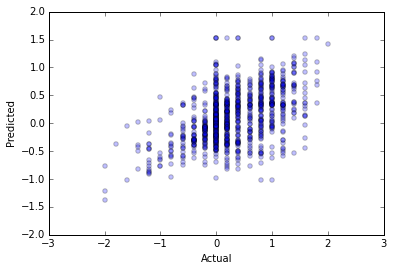

In [878]:
plt.scatter(df['Y_meas'], Y_predict,alpha=0.25);plt.xlabel('Actual');plt.ylabel('Predicted')

In [787]:
clf = sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

(900, 31)

## End more text processing

In [470]:
# inferred directly from word counts
# index is command-line index, NOT LDA-vis index
topics_used = [2, 10, 15, 23, 26, 0] # 0 holds everything else
topic_probabilities = {15:0.114, 23:0.106, 26:0.078, 10:0.061, 2:0.043}
norm = np.sum(list(topic_probabilities.values()))
topic_probabilities[0] = norm
sentiments = {15:-1, 23:-1, 26:1, 10:1, 2:1, 0:0}

In [471]:
sentiments

{0: 0, 2: 1, 10: 1, 15: -1, 23: -1, 26: 1}

In [457]:
topic_df.shape

(29613, 30)

In [440]:
dictionary_backer.num_nnz?

In [411]:
topic_df.loc[word_to_index['not']][0]  

1.0

In [341]:
lda_backer.log_perplexity?

In [362]:
lda_backer.show_topic(10)

[(0.032624813053641587, u'received'),
 (0.030338266220286243, u'not'),
 (0.019662311123613656, u'tracking'),
 (0.015154434787507096, u'number'),
 (0.012933797156675447, u'email'),
 (0.012598451273916081, u'mine'),
 (0.010726303255006134, u'today'),
 (0.010256895996630546, u'please'),
 (0.010078830382511691, u"'m"),
 (0.0095858981960620804, u"'s")]

In [525]:
dictionary_backer.doc2bow(['refund', 'refund'])

[(1094, 2)]

In [524]:
lda_backer.inference([dictionary_backer.doc2bow(['refund', 'refund'])])

(array([[ 0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  2.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333,
          0.03333333,  0.03333333,  0.03333333,  0.03333333,  0.03333333]]),
 None)

In [344]:
lda_backer.log_perplexity([dictionary_backer.doc2bow(['refund', 'refund'])])

-269027.53046116233

## Run LDA with more iterations

In [345]:
lda_backer_more_iterations, corpus_backer, dictionary_backer, id2word_backer = run_lda(backer_processed, n_topics)

In [347]:
pyLDAvis.gensim.prepare(lda_backer_more_iterations, corpus_backer, dictionary_backer)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
5      10.129880        1       1 -0.059044  0.015322
13      9.538416        1       2 -0.040224 -0.153822
4       8.225637        1       3 -0.046476 -0.035915
8       8.118821        1       4 -0.054328 -0.109029
10      7.383463        1       5 -0.015938 -0.161573
20      7.050383        1       6 -0.033017 -0.148733
18      6.994051        1       7 -0.060778 -0.070210
21      6.359427        1       8 -0.073618  0.029689
26      4.446122        1       9 -0.089532  0.053849
15      3.390935        1      10 -0.078659  0.090539
19      3.226945        1      11 -0.069416  0.030582
2       3.006466        1      12 -0.071483  0.077049
7       2.569656        1      13 -0.051713 -0.153829
23      2.532885        1      14 -0.080928  0.014432
24      1.993562        1      15 -0.040169 -0.021838
1       1.987182        1      16 -0.077885  0.093454
0       1.986096        1      17 -0.000204 -0.026396
22      1.776833        1      18 -0.073643  0.112987
17      1.412292        1      19 -0.033406 -0.055390
27      1.109825        1      20 -0.061336  0.057965
6       1.101248        1      21  0.040412 -0.125097
25      0.885050        1      22  0.002773  0.040703
3       0.776257        1      23  0.002804  0.125086
16      0.750225        1      24  0.005623  0.252226
28      0.741780        1      25  0.172148 -0.084685
29      0.698926        1      26 -0.003122  0.009062
12      0.639180        1      27  0.024742  0.019699
14      0.489942        1      28  0.053662  0.087693
9       0.401730        1      29  0.379509 -0.068430
11      0.276784        1      30  0.433249  0.104610, topic_info=      Category           Freq         Term   Total  loglift  logprob
101    Default   27881.000000           --   27881  30.0000  30.0000
42     Default  111724.000000            @  111724  29.0000  29.0000
451    Default   18184.000000          app   18184  28.0000  28.0000
1094   Default   12372.000000       refund   12372  27.0000  27.0000
173    Default   12743.000000       backed   12743  26.0000  26.0000
28     Default   41907.000000      project   41907  25.0000  25.0000
24     Default  121117.000000          not  121117  24.0000  24.0000
835    Default   13478.000000      printer   13478  23.0000  23.0000
403    Default   22932.000000     received   22932  22.0000  22.0000
747    Default   29322.000000      product   29322  21.0000  21.0000
343    Default   28590.000000     shipping   28590  20.0000  20.0000
306    Default   26895.000000       please   26895  19.0000  19.0000
23     Default   15787.000000        money   15787  18.0000  18.0000
31     Default   39442.000000       thanks   39442  17.0000  17.0000
270    Default   33019.000000  kickstarter   33019  16.0000  16.0000
410    Default   29764.000000          use   29764  15.0000  15.0000
99     Default   94687.000000           's   94687  14.0000  14.0000
307    Default   21799.000000       pledge   21799  13.0000  13.0000
786    Default    8988.000000          usb    8988  12.0000  12.0000
91     Default   34264.000000       update   34264  11.0000  11.0000
14573  Default    7063.000000         pono    7063  10.0000  10.0000
578    Default   10997.000000      battery   10997   9.0000   9.0000
5707   Default    4324.000000       shirts    4324   8.0000   8.0000
26     Default   28424.000000       people   28424   7.0000   7.0000
874    Default    4904.000000     facebook    4904   6.0000   6.0000
3008   Default    8043.000000      android    8043   5.0000   5.0000
397    Default   14734.000000         mine   14734   4.0000   4.0000
521    Default   13441.000000       device   13441   3.0000   3.0000
3470   Default   11086.000000        phone   11086   2.0000   2.0000
993    Default   15946.000000      creator   15946   1.0000   1.0000
...        ...            ...          ...     ...      ...      ...
23256  Topic30       

## OTHER

In [215]:
# find comments with greatest probability of a given topic
backer_processed_lda = backer_processed.copy(deep=True)

backer_processed.head(2)

comment       date  project_id  \
0  as one of the biggest fans of the game tetris ... 2014-09-30      182943   
1  got it! (20 nov) thanks. can't wait to experim... 2014-12-31      182943   

                                           tokenized  \
0  [as, one, of, the, biggest, fans, of, the, gam...   
1  [got, it, !, (, 20, nov, ), thanks, ., ca, n't...   

                                             stopped  
0  [people, money, hard, thanks, mentioned, bit, ...  
1        [20, kamiel, experiment, thanks, nov, wait]

In [219]:
from collections import defaultdict

In [223]:
x = lda_backer[dictionary_backer.doc2bow(backer_processed.iloc[200]['stopped'])]
d = defaultdict(dict)
for t in range(30):
    d[t] = 0
for t in x:
    d[t[0]] = t[1]

In [227]:
df = pd.DataFrame(d,index=[0])

In [228]:
df

0   1   2   3   4   5   6   7         8        9  ...  20  21  22  23  24  \
0   0   0   0   0   0   0   0   0  0.542976  0.41258 ...   0   0   0   0   0   

   25  26  27  28  29  
0   0   0   0   0   0  

[1 rows x 30 columns]

In [250]:
pyLDAvis.gensim.prepare(lda_creator, corpus_creator, dictionary_creator)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
12     14.093694        1       1  0.123954 -0.144533
27     11.601042        1       2  0.144848 -0.065189
26      9.121399        1       3  0.141154  0.012964
1       8.891952        1       4  0.139579  0.029897
4       8.308386        1       5  0.134755 -0.064005
14      8.180766        1       6  0.154570 -0.103241
25      4.241549        1       7  0.135672  0.117420
19      3.981318        1       8  0.147091 -0.003111
23      3.583600        1       9  0.112316  0.139950
16      3.451422        1      10  0.106043 -0.128959
2       3.190911        1      11  0.131679  0.124844
9       3.102632        1      12  0.115054  0.127854
6       2.455423        1      13  0.076165  0.158783
28      1.969528        1      14  0.063607  0.034157
17      1.895869        1      15  0.082721  0.082732
3       1.867684        1      16  0.069906 -0.014286
29      1.813557        1      17  0.086274 -0.048062
21      1.575188        1      18  0.029112 -0.197710
22      1.318721        1      19 -0.083034 -0.281450
7       1.310552        1      20  0.012332 -0.129567
0       0.837136        1      21 -0.011651  0.013406
24      0.676828        1      22 -0.120440  0.016689
8       0.675937        1      23 -0.075133  0.216502
10      0.591670        1      24 -0.067528  0.100231
11      0.433676        1      25 -0.162527 -0.061375
5       0.192859        1      26 -0.294252  0.036013
20      0.179202        1      27 -0.291003  0.011177
15      0.174701        1      28 -0.294797  0.022568
13      0.173873        1      29 -0.294843 -0.007954
18      0.108925        1      30 -0.311621  0.004254, topic_info=      Category          Freq         Term  Total  loglift  logprob
41     Default  60937.000000            @  60937  30.0000  30.0000
63     Default  10423.000000           hi  10423  29.0000  29.0000
251    Default  11405.000000        thank  11405  28.0000  28.0000
33     Default  21840.000000       thanks  21840  27.0000  27.0000
374    Default   5170.000000           --   5170  26.0000  26.0000
247    Default  11943.000000      support  11943  25.0000  25.0000
790    Default   5676.000000         team   5676  24.0000  24.0000
380    Default   3896.000000          hey   3896  23.0000  23.0000
90     Default  10817.000000       update  10817  22.0000  22.0000
2149   Default   5386.000000          app   5386  21.0000  21.0000
1333   Default   3905.000000      battery   3905  20.0000  20.0000
78     Default   5253.000000      project   5253  19.0000  19.0000
307    Default   9800.000000       please   9800  18.0000  18.0000
180    Default   8160.000000  kickstarter   8160  17.0000  17.0000
733    Default   3608.000000        power   3608  16.0000  16.0000
174    Default   4493.000000         http   4493  15.0000  15.0000
391    Default   9185.000000      backers   9185  14.0000  14.0000
199    Default  25457.000000          not  25457  13.0000  13.0000
94     Default  19611.000000           's  19611  12.0000  12.0000
2626   Default   2175.000000      regards   2175  11.0000  11.0000
237    Default   8539.000000     shipping   8539  10.0000  10.0000
17438  Default   1725.000000         zano   1725   9.0000   9.0000
288    Default   4759.000000        email   4759   8.0000   8.0000
308    Default   4271.000000       pledge   4271   7.0000   7.0000
549    Default   2933.000000    regarding   2933   6.0000   6.0000
735    Default   1685.000000      printer   1685   5.0000   5.0000
35     Default   8330.000000          use   8330   4.0000   4.0000
1069   Default   1846.000000        light   1846   3.0000   3.0000
440    Default   2989.000000          usb   2989   2.0000   2.0000
1503   Default   1232.000000          box   1232   1.0000   1.0000
...        ...           ...          ...    ...      ...      ...
23297  Topic30     28.809525         auch     30   6.5683  -4.5051
23322  Topic30    

In [ ]:
def get_toppic_weights(row, lda):
    